
<center>
<img src="../images/fscampus_small2.png" width="1200"/>
</center>


***Finance I (OFIN)-SS2025***

**Dr. Omer Cayirli**

Lecturer in Empirical Finance

omer.cayirli@vgu.edu.vn

---

## Lecture 08
---

### Outline
*   Risk and Return
    *   Optimal Portfolio Choice
    *   The Capital Asset Pricing Model
---

### Risk in Investments

**Two fundamental questions for investments:**

* What is risk and how can we measure it?

* How much additional return should we earn for bearing an additional unit of risk?

---

Fetching daily data from 1999-12-31 to 2025-06-03
Data will be resampled to monthly. Using QQQ close vs. adjusted for Nasdaq-100.


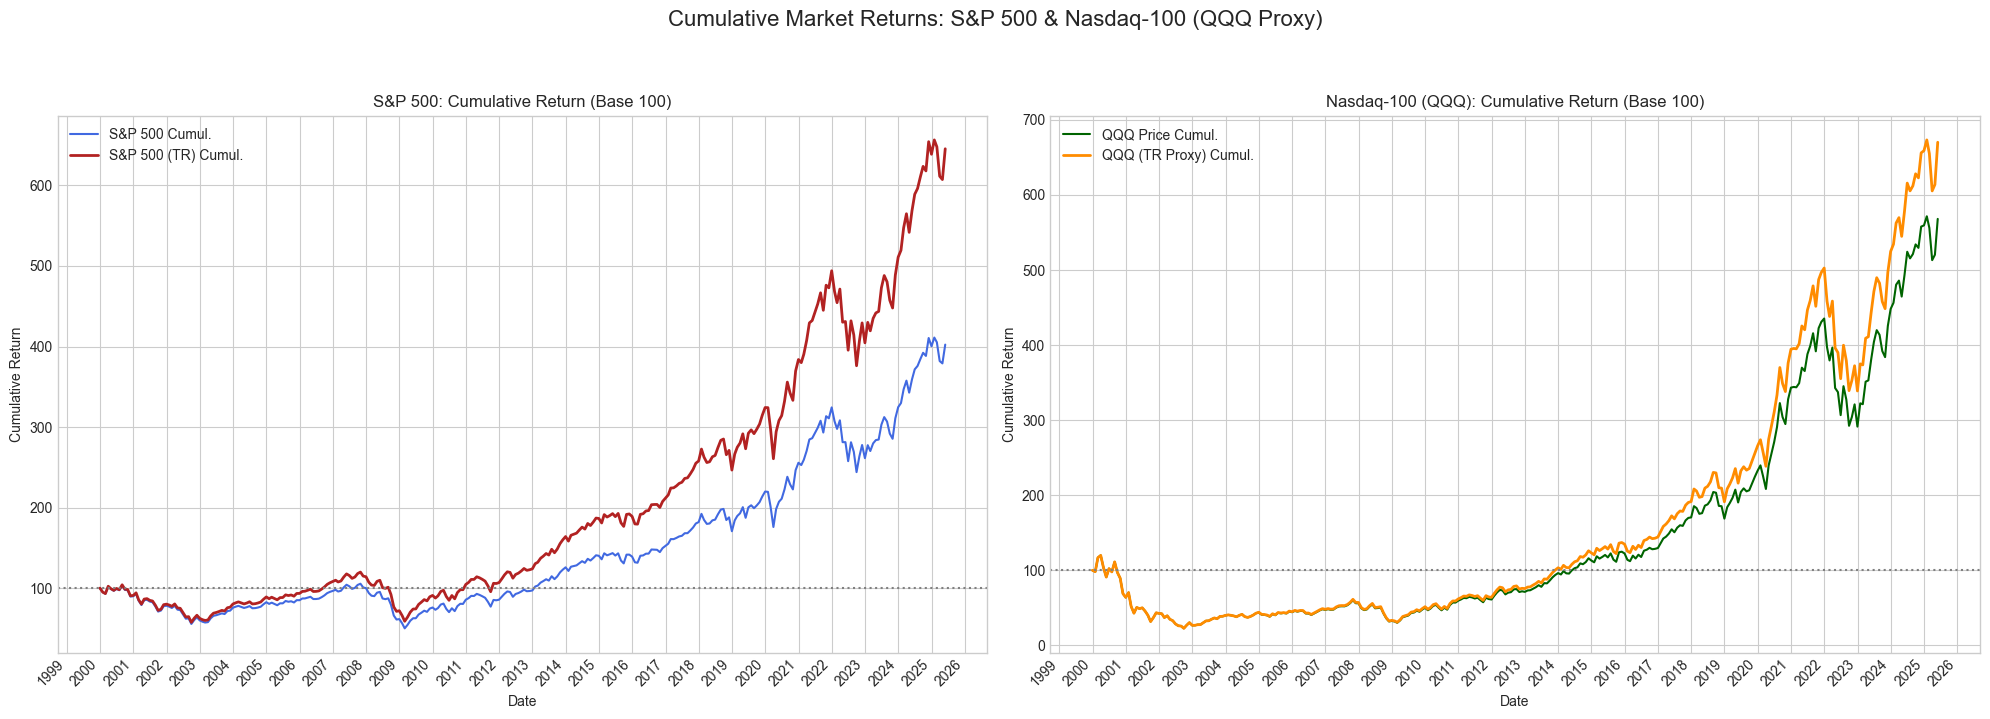

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, timedelta

# --- 1. Define Tickers and Date Range ---
tickers_base = ['^GSPC', '^SP500TR']
start_date = "1999-12-31"

today = date.today()
first_day_of_current_month = today.replace(day=1)
end_date_dt = first_day_of_current_month - timedelta(days=1)
end_date_str = end_date_dt.strftime('%Y-%m-%d')
yf_end_date = (end_date_dt + timedelta(days=3)).strftime('%Y-%m-%d')

print(f"Fetching daily data from {start_date} to {yf_end_date}")
print("Data will be resampled to monthly. Using QQQ close vs. adjusted for Nasdaq-100.")

# --- 2. Download Daily Data and Resample to Monthly ---
downloaded_monthly_series = {}

for ticker in tickers_base:
    try:
        daily_data = yf.download(
            ticker,
            start=start_date,
            end=yf_end_date,
            progress=False,
            auto_adjust=True
        )
        if not daily_data.empty and 'Close' in daily_data.columns:
            monthly = daily_data['Close'].resample('ME').last()
            monthly = monthly[monthly.index <= pd.to_datetime(end_date_str)]
            if len(monthly) > 1:
                downloaded_monthly_series[ticker] = monthly.copy()
    except Exception as e:
        print(f"Failed {ticker}: {e}")

try:
    ticker = 'QQQ'
    daily_raw = yf.download(
        ticker,
        start=start_date,
        end=yf_end_date,
        progress=False,
        auto_adjust=False 
    )
    if not daily_raw.empty and 'Close' in daily_raw.columns:
        monthly_raw = daily_raw['Close'].resample('ME').last()
        monthly_raw = monthly_raw[monthly_raw.index <= pd.to_datetime(end_date_str)]
        if len(monthly_raw) > 1:
            downloaded_monthly_series['QQQ_raw'] = monthly_raw.copy()
except Exception as e:
    print(f"Failed QQQ raw: {e}")

try:
    ticker = 'QQQ'
    daily_adj = yf.download(
        ticker,
        start=start_date,
        end=yf_end_date,
        progress=False,
        auto_adjust=True 
    )
    if not daily_adj.empty and 'Close' in daily_adj.columns:
        monthly_adj = daily_adj['Close'].resample('ME').last()
        monthly_adj = monthly_adj[monthly_adj.index <= pd.to_datetime(end_date_str)]
        if len(monthly_adj) > 1:
            downloaded_monthly_series['QQQ_adj'] = monthly_adj.copy()
except Exception as e:
    print(f"Failed QQQ adj: {e}")

# --- 3. Combine into DataFrame ---
price_data_processed = pd.DataFrame()
if downloaded_monthly_series:
    try:
        price_data_processed = pd.concat(downloaded_monthly_series, axis=1)
        if isinstance(price_data_processed.columns, pd.MultiIndex):
            price_data_processed.columns = price_data_processed.columns.get_level_values(0)
        price_data_processed.sort_index(inplace=True)
        price_data_processed.dropna(how='all', inplace=True)
    except Exception as ex:
        print(f"Error creating DataFrame: {ex}")
else:
    print("No data to combine.")

if price_data_processed.empty:
    print("No data available. Exiting.")
    raise SystemExit

# --- 4. Prepare for Plotting ---
rename_map = {
    '^GSPC':      'S&P 500',
    '^SP500TR':  'S&P 500 (TR)',
    'QQQ_raw':   'QQQ Price',
    'QQQ_adj':   'QQQ (TR Proxy)'
}
price_data_processed.rename(columns=rename_map, inplace=True)
price_data_processed.index = pd.to_datetime(price_data_processed.index)

sp500_price = rename_map.get('^GSPC') # Use .get to avoid KeyError if a ticker failed
sp500_tr    = rename_map.get('^SP500TR')
nas_raw     = rename_map.get('QQQ_raw')
nas_tr      = rename_map.get('QQQ_adj')

# --- 5. Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
# Create two subplots side-by-side for cumulative returns
fig, ax = plt.subplots(1, 2, figsize=(20, 7), sharex=True) # 1 row, 2 columns

def has(df, col):
    return col is not None and col in df.columns and df[col].notna().any()

# S&P 500 Cumulative Return (Left Plot)
if has(price_data_processed, sp500_price) and has(price_data_processed, sp500_tr):
    p0 = price_data_processed[sp500_price].dropna().iloc[0] if price_data_processed[sp500_price].notna().any() else None
    t0 = price_data_processed[sp500_tr].dropna().iloc[0] if price_data_processed[sp500_tr].notna().any() else None
    if p0 is not None and t0 is not None:
        ax[0].plot(price_data_processed.index,
                     price_data_processed[sp500_price]/p0*100,
                     label=f'{sp500_price} Cumul.', color='royalblue', lw=1.5)
        ax[0].plot(price_data_processed.index,
                     price_data_processed[sp500_tr]/t0*100,
                     label=f'{sp500_tr} Cumul.', color='firebrick', lw=2)
        ax[0].axhline(100, color='grey', ls=':')
ax[0].set_title('S&P 500: Cumulative Return (Base 100)')
ax[0].set_ylabel('Cumulative Return')
ax[0].set_xlabel('Date')
ax[0].legend(loc='upper left')
ax[0].grid(True)

# Nasdaq-100 Cumulative Return (Right Plot)
if has(price_data_processed, nas_raw) and has(price_data_processed, nas_tr):
    r0 = price_data_processed[nas_raw].dropna().iloc[0] if price_data_processed[nas_raw].notna().any() else None
    a0 = price_data_processed[nas_tr].dropna().iloc[0] if price_data_processed[nas_tr].notna().any() else None
    if r0 is not None and a0 is not None:
        ax[1].plot(price_data_processed.index,
                     price_data_processed[nas_raw]/r0*100,
                     label=f'{nas_raw} Cumul.', color='darkgreen', lw=1.5)
        ax[1].plot(price_data_processed.index,
                     price_data_processed[nas_tr]/a0*100,
                     label=f'{nas_tr} Cumul.', color='darkorange', lw=2)
        ax[1].axhline(100, color='grey', ls=':')
ax[1].set_title('Nasdaq-100 (QQQ): Cumulative Return (Base 100)')
ax[1].set_ylabel('Cumulative Return')
ax[1].set_xlabel('Date')
ax[1].legend(loc='upper left')
ax[1].grid(True)

# Format x-axis for both plots
for i in [0,1]:
    ax[i].xaxis.set_major_locator(mdates.YearLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax[i].xaxis.set_minor_locator(mdates.MonthLocator(interval=6))
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha='right')

fig.suptitle('Cumulative Market Returns: S&P 500 & Nasdaq-100 (QQQ Proxy)', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


---

### Expected and Excess Returns on Investments

**Expected Return**
* The level of total return realized during the holding period involves uncertainty.

* The expected rate of return is the probability-weighted average of the rates of return that will occur in each scenario.

**Excess Return** 
* The additional return an asset provides over a risk-free rate.

**Expected Excess Return** 

* The probability-weighted average of all possible excess returns.

---

### Portfolio Risk and Return
An investor constructs a portfolio by purchasing 150 shares of Quantum Computing Inc. (QCI) at $80 per share and 300 shares of Global Foods Corp. (GFC) at $50 per share. Over the next quarter, QCI's stock price rises to $92 per share, while GFC's stock price declines to $48 per share.

*   What was the initial value of the portfolio and the initial weight of each stock?
*   What is the new value of the portfolio, and what percentage return did it earn?
*   After the price change, what are the new portfolio weights for QCI and GFC?
    
    ---

Calculate the initial market value of the holdings in each stock and the total portfolio value.

*   Initial Value of QCI = $150 \text{ shares} \times \$80/\text{share} = \$12,000$
*   Initial Value of GFC = $300 \text{ shares} \times \$50/\text{share} = \$15,000$
*   Total Initial Portfolio Value = $\$12,000 + \$15,000 = \$27,000$

Calculate the initial portfolio weights ($w_i$).

$ w_i = \frac{\text{Value of Stock } i}{\text{Total Portfolio Value}} $

$w_{QCI} = \frac{\$12,000}{\$27,000} = \frac{4}{9} \approx 44.44\% \quad \text{and} \quad w_{GFC}= \frac{\$15,000}{\$27,000} = \frac{5}{9} \approx 55.56\% $

*   New Value of QCI = $150 \text{ shares} \times \$92/\text{share} = \$13,800$
*   New Value of GFC = $300 \text{ shares} \times \$48/\text{share} = \$14,400$
*   New Total Portfolio Value = $\$13,800 + \$14,400 = \$28,200$

$$ R_p = \frac{\text{New Value} - \text{Initial Value}}{\text{Initial Value}} \quad \Rightarrow \quad R_p = \frac{\$28,200 - \$27,000}{\$27,000} = \frac{\$1,200}{\$27,000} \approx 0.0444 $$

$ w'_i = \frac{\text{New Value of Stock } i}{\text{New Total Portfolio Value}} $

$w'_{QCI} = \frac{\$13,800}{\$28,200} \approx 0.4894 \quad (48.94\%) \quad \text{and} \quad w'_{GFC} = \frac{\$14,400}{\$28,200} \approx 0.5106 \quad (51.06\%) $

---


### Portfolio Risk and Return

An investment advisor is structuring a portfolio for a new client. The portfolio is diversified across three main asset classes: a U.S. Equity Fund, an International Equity Fund, and a Corporate Bond Fund. The portfolio allocation is 50% to the U.S. Equity Fund, 30% to the International Equity Fund, and 20% to the Corporate Bond Fund. The projected annual returns for these funds are 12%, 14%, and 4.5%, respectively. What is the expected annual return for the entire portfolio?

$ E[R_p] = (w_{US} \times E[R_{US}]) + (w_{Intl} \times E[R_{Intl}]) + (w_{Bonds} \times E[R_{Bonds}]) $

$ E[R_p] = (0.50 \times 0.12) + (0.30 \times 0.14) + (0.20 \times 0.045) \quad \Rightarrow \quad E[R_p] = 0.060 + 0.042 + 0.009 \quad \Rightarrow \quad E[R_p] = 0.111 $


---


### Portfolio Risk and Return

You have $50,000 to invest. You are considering two funds: a High-Growth Tech Fund with an expected return of 18% and a Stable Dividend Fund with an expected return of 6%. If you want to create a portfolio with a target expected return of 14.4%, how much money should you allocate to each fund?

$ E[R_p] = w_T E[R_T] + (1 - w_T) E[R_D] $

$ 0.144 = w_T(0.18) + (1 - w_T)(0.06) \quad \Rightarrow \quad 0.144 = 0.18w_T + 0.06 - 0.06w_T \quad \Rightarrow \quad w_T = \frac{0.084}{0.12} = 0.70 $

**Investment in High-Growth Tech Fund:** $\quad 0.70 \times \$50,000 = \$35,000 $

**Investment in Stable Dividend Fund:** $\quad 0.30 \times \$50,000 = \$15,000 $

---


### Risk in Investments

* One of the main functions of financial markets is to enable economic agents to transfer their risks to willing counterparties or to assume the risks of others.

* Financial risks are generally associated with uncertainty about the outcome of an investment.
    * Volatility (variance) in returns is the main risk criterion used.

    * Risk measures are not limited to volatility:
        * Value at Risk (VaR)
            * Measures the potential loss in value of a risky asset or portfolio over a defined period for a given confidence interval.
            * What is the most I can expect to lose, X% of the time, over a specific holding period?
        * Conditional Value at Risk (CVaR) / Expected Shortfall (ES)
            * What is the expected loss, conditional on the loss exceeding the VaR?
            * Quantifies the losses that might be encountered in the tail.
        * Semivariance
            * Measures the dispersion of all observations that fall below the mean or target value of a set of data.

---


### Risk in Investments

*   Modern portfolio theory and asset pricing models often begin with the assumption of a normal distribution of returns.
*   The normality assumption ensures that the standard deviation is an exact measure of risk.
*   A normal distribution;
    *   Fully defined by its mean ($\mu$) and variance ($\sigma^2$).
    *   Symmetrical, bell-shaped curve.
*   The mean of the standard normal distribution is 0 and the variance is 1.
    *   The mean or expected value ($\mu$) of the distribution is known as the location parameter.
    *   A normal distribution with $\mu \ne 0$ can be easily converted to a standard normal distribution ($\mu=0, \sigma=1$).
    *   The standard deviation ($\sigma$) of the distribution is known as the distribution parameter.
    *   When $\mu$ is constant, changes in distribution parameter affect the shape of the distribution.

<center>
<img src="../figures/location_and_scale.png" width="840"/>
</center>

---

### Risk in Investments

**The Volatility of a Two-Stock Portfolio**

| Year | Alpha Tech | Beta Retail | Gamma Energy | 1/2 AT + 1/2 BR | 1/2 BR + 1/2 GE |
| :--: | :--------: | :---------: | :----------: | :------------: | :------------: |
| **Stock Returns** |            |             |              |                |                |
| 2015 | 20%        | 10%         | -3%          | 15.0%          | 3.5%           |
| 2016 | -5%        | -2%         | 25%          | -3.5%          | 11.5%          |
| 2017 | 15%        | 12%         | -2%          | 13.5%          | 5.0%           |
| 2018 | 10%        | 8%          | 20%          | 9.0%           | 14.0%          |
| 2019 | -10%       | -5%         | -8%          | -7.5%          | -6.5%          |
| 2020 | 8%         | 5%          | 30%          | 6.5%           | 17.5%          |
| **Average Return** | 6.3%       | 4.7%        | 10.3%        | 5.5%           | 7.5%           |
| **Volatility**     | 11.6%      | 6.8%        | 16.5%        | 9.1%           | 8.7%           |

* By combining stocks into a portfolio, we reduce risk through diversification.  
  * When the prices of the stocks do not move identically, some of the risk is averaged out in a portfolio.
* The amount of risk that is eliminated in a portfolio depends on the degree to which the stocks face common risks, and their prices move together.

---

### Risk in Investments

* Covariance and Correlation

* Covariance is a measure of how much two variables change together.
    * Covariance is the expected product of the deviations of returns from their means.

* Correlation is a statistical measure that expresses the extent to which two variables are linearly related.
    * The correlation between two stocks has the same sign as their covariance.
    * Correlation is always between -1 and +1.

* Covariance and Correlation
  $$ Cov(R_i, R_j) = E[(R_i – E[R_i])(R_j – E[R_j])] $$
  $$ Cor(R_i, R_j) = \frac{Cov(R_i, R_j)}{\sigma_i \sigma_j} $$

---

### Risk in Investments

**What are the covariance and the correlation between Alpha Tech (AT) and Beta Retail (BR)? Between Beta Retail (BR) and Gamma Energy (GE)?**

| Year | (R<sub>AT</sub> – R̄<sub>AT</sub>) | (R<sub>BR</sub> – R̄<sub>BR</sub>) | (R<sub>GE</sub> – R̄<sub>GE</sub>) | (Dev<sub>AT</sub>×Dev<sub>BR</sub>) | (Dev<sub>BR</sub>×Dev<sub>GE</sub>) |
| :--: | :--------------------------------: | :--------------------------------: | :--------------------------------: | :--------------------------------: | :--------------------------------: |
|      | **Deviation from Mean**            |                                    |                                    | **AT & BR**                        | **BR & GE**                        |
| 2015 | 13.67 %                            | 5.33 %                             | –13.33 %                           | 0.0073                             | –0.0071                            |
| 2016 | –11.33 %                           | –6.67 %                            | 14.67 %                            | 0.0076                             | –0.0098                            |
| 2017 | 8.67 %                             | 7.33 %                             | –12.33 %                           | 0.0064                             | –0.0090                            |
| 2018 | 3.67 %                             | 3.33 %                             | 9.67 %                             | 0.0012                             | 0.0032                             |
| 2019 | –16.33 %                           | –9.67 %                            | –18.33 %                           | 0.0158                             | 0.0177                             |
| 2020 | 1.67 %                             | 0.33 %                             | 19.67 %                            | 0.0001                             | 0.0007                             |
| **Sum** |                                  |                                    |                                    | **0.0383**                         | **–0.0043**                        |

**Covariance:** $\quad \mathrm{Cov}(R_i,R_j)
=\frac{1}{T-1}\sum_{t=1}^T\bigl(R_{i,t}-\bar R_i\bigr)\bigl(R_{j,t}-\bar R_j\bigr)$  

$\text{AT and BR:} \frac{0.0383}{6-1}=0.0077 \qquad \text{and} \qquad \text{BR and GE:} \frac{-0.0043}{6-1}=-0.0009$  

**Correlation:** $\quad \mathrm{Corr}(R_i,R_j) =\frac{\mathrm{Cov}(R_i,R_j)}{\sigma_i\,\sigma_j} $  

Using $\sigma_{AT}=11.6\%$, $\sigma_{BR}=6.8\%$, $\sigma_{GE}=16.5\%$:  

$\text{AT and BR:} \frac{0.0077}{0.116\times0.068}\approx0.97 \qquad \text{and} \qquad \text{BR and GE:} \frac{-0.0009}{0.068\times0.165}\approx-0.08$

---

### Risk in Investments

**Portfolio Return**

$$ E(r_p) = w_1 E(r_1) + w_2 E(r_2) + \dots + w_N E(r_N) \quad \Rightarrow \quad E(r_p) = \sum_{n=1}^{N} w_n E(r_n) $$

**Portfolio Risk**

$$ \sigma^2(r_p) = p_1 \cdot (r_{p,1} - E(r_p))^2 + p_{2} \cdot (r_{p,2} - E(r_p))^2 + \dots + p_{n} \cdot (r_{p,n} - E(r_p))^2 \quad \text{and} \quad \sigma_p = \sqrt{\sigma^2(r_p)} $$

* For an asset, the variance is a measure of the dispersion of possible returns on the asset around the expected return.

* Similarly, portfolio variance measures the dispersion of possible portfolio returns around the expected portfolio return.

* **How should we calculate the standard deviation (risk) of the portfolio consisting of these two assets?**

---

### Risk in Investments

*   When calculating the expected return of the portfolio, we take the weighted average of the expected returns of the assets.

*   We cannot use the same method for variance or standard deviation (i.e., simply taking a weighted average of individual asset variances is incorrect due to the effect of covariances).

*   **Covariance:**
    *   Measures the directional relationship between the returns of two assets.
    *   At the portfolio level, the sign and magnitude of the covariances between pairs of assets significantly impact the overall volatility (risk) of the portfolio.

*   For two assets, $i$ and $j$, when considering $N$ possible states of the world (scenarios), each with a probability $p_k$:

    $ \text{Cov}(r_i, r_j) = p_1 \cdot [r_{i,1} - E(r_i)] \cdot [r_{j,1} - E(r_j)] + p_2 \cdot [r_{i,2} - E(r_i)] \cdot [r_{j,2} - E(r_j)] + \dots + p_N \cdot [r_{i,N} - E(r_i)] \cdot [r_{j,N} - E(r_j)] $

    $ \text{Cov}(r_i, r_j) = \sum_{k=1}^{N} p_k \cdot [r_{i,k} - E(r_i)] \cdot [r_{j,k} - E(r_j)] $
    
    Where:
    *   $\text{Cov}(r_i, r_j)$ is the covariance between the returns of asset $i$ and asset $j$.
    *   $N$ is the number of possible states/scenarios and $p_k$ is the probability of state/scenario $k$ occurring.
    *   $r_{i,k}$ is the return of asset $i$ if state/scenario $k$ occurs and $E(r_i)$ is the expected return of asset $i$.
    *   $r_{j,k}$ is the return of asset $j$ if state/scenario $k$ occurs and $E(r_j)$ is the expected return of asset $j$.

---


### Risk in Investments
**What are the covariance and the correlation between Stock A and B?**

| State of Economy | Probability | $R_A$      | $R_B$       | $P_i*(R_A–E(R_A))^2$ | $P_i*(R_B–E(R_B))^2$ | $P_i*(R_A–E(R_A))(R_B–E(R_B))$ |
| :--------------- | ----------: | -------:| --------:| --------------:| --------------:| ----------------------:|
| Downturn         |        25%  |   4.00% |  –10.00% |         0.00051 |         0.00563 |               0.00169 |
| Stable           |        50%  |   8.00% |    5.00% |         0.00001 |         0.00000 |               0.00000 |
| Growth           |        25%  |  14.00% |   20.00% |         0.00076 |         0.00563 |               0.00206 |
| **E(R)**         |             | **8.50%**| **5.00%**|                 |                 |                        |
| **σ²**           |             |         |          | **0.00128**     | **0.01125**     |                        |
| **σ**            |             |         |          | **3.57%**       | **10.61%**      |                        |
| **Cov($R_A$,$R_B$)**   |             |         |          |                 |                 | **0.00375**            |
| **Corr($R_A$,$R_B$)**  |             |         |          |                 |                 | **0.99**               |

**Covariance:** $\quad Cov(R_A,R_B) = \sum_{i} p_i\,(R_{A,i}-\bar R_A)\,(R_{B,i}-\bar R_B) = 0.00375 $

**Correlation:** $\quad Corr(R_A,R_B) = \frac{Cov(R_A,R_B)}{\sigma_A\,\sigma_B} = \frac{0.00375}{0.035707\times0.106066} \approx 0.99$

---

### Risk in Investments

$$ \rho_{i,j} = \frac{\operatorname{Cov}(r_i, r_j)}{\sigma_i\,\sigma_j} \qquad \text{and} \qquad  \text{Cov}(r_i, r_j) = \rho_{i,j} \sigma_i \sigma_j$$

*   For two assets (portfolio variance $\sigma_p^2$):

$$ \sigma_p^2 = w_1^2\sigma_1^2 + w_2^2\sigma_2^2 + 2w_1w_2\rho_{12}\sigma_1\sigma_2 $$

* Consider the portfolio of Alpha Tech (AT) and Beta Retail (BR):

  * $σ_{AT} = 11.6\% \implies \text{var}_{AT} = 0.116^2 = 0.01346$  
  * $σ_{BR} = 6.8\% \implies \text{var}_{BR} = 0.068^2 = 0.00462$  
  * $\text{cov}(AT,BR) = 0.0077$  

  * Portfolio variance (equal weights): $\quad \Rightarrow \quad  \text{var}_p = 0.5^2 \times 0.01346 + 0.5^2 \times 0.00462 + 2\times0.5\times0.5\times0.0077 = 0.00837 $

  * Portfolio volatility: $\quad \Rightarrow \quad σ_p = \sqrt{0.00837} \approx 9.15\% $

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- DEFAULT VALUES ---
DEFAULT_ER_A = 0.0900       # Expected Return Asset A
DEFAULT_STD_A = 0.0250      # Standard Deviation Asset A
DEFAULT_ER_B = 0.1200       # Expected Return Asset B
DEFAULT_STD_B = 0.0450      # Standard Deviation Asset B
DEFAULT_CORR_AB = -0.8000   # Correlation between Asset A and B
DEFAULT_COV_AB = -0.0009  # Covariance between Asset A and B


# --- Input Parameter Widgets ---
# Style for descriptions (labels)
style_desc = {'description_width': '200px'} # Consistent description width

# Layout for the input FloatText fields themselves (the box part)
input_field_layout = widgets.Layout(width='130px') # Make input boxes a bit wider for cov

# Combined layout for description + input field for FloatText
# Total width needed: description_width + input_field_layout.width + some padding
widget_layout_left = widgets.Layout(width='350px') # Overall widget width for left column
widget_layout_right = widgets.Layout(width='350px')# Overall widget width for right column

er_a_widget = widgets.FloatText(value=DEFAULT_ER_A, step=0.0001, description='Expected Return Asset A (E(rA)):', style=style_desc, layout=widget_layout_left)
std_a_widget = widgets.FloatText(value=DEFAULT_STD_A, step=0.0001, description='Std. Dev. Asset A (σA):', style=style_desc, layout=widget_layout_left)
# Correlation: default -0.8986 from your image
corr_ab_widget = widgets.FloatText(value=DEFAULT_CORR_AB, step=0.0001, min=-1, max=1, description='Correlation (ρAB):', style=style_desc, layout=widget_layout_left)
# Covariance: default -0.000388 from your image, ensure format for display
cov_ab_widget = widgets.FloatText(value=DEFAULT_COV_AB, step=0.000001, description='Covariance (Cov(rA, rB)):', style=style_desc, layout=widget_layout_left)


er_b_widget = widgets.FloatText(value=DEFAULT_ER_B, step=0.0001, description='Expected Return Asset B (E(rB)):', style=style_desc, layout=widget_layout_right)
std_b_widget = widgets.FloatText(value=DEFAULT_STD_B, step=0.0001, description='Std. Dev. Asset B (σB):', style=style_desc, layout=widget_layout_right)


# --- Output Widgets ---
output_gmvp = widgets.Output()
output_table = widgets.Output()
output_plot = widgets.Output()

# --- Recalculate Button ---
recalculate_button = widgets.Button(
    description="Recalculate & Plot",
    button_style='info',
    tooltip='Click to update frontiers and table',
    icon='refresh',
    layout=widgets.Layout(width='auto', min_width='150px', margin='10px 0 0 0')
)

# --- Linking Logic for Correlation and Covariance ---
updating_internally = False

def format_float_widget_value(widget, value, precision):
    """Helper to format and set widget value, avoiding excessive observer triggers."""
    try:
        if pd.isna(value): # Handle NaN case for correlation
            formatted_value_str = "NaN"
            # For FloatText, setting to actual np.nan might clear it or cause issues,
            # It's better to let the user see "NaN" if they type it or if it's calculated
            # However, FloatText doesn't directly support "NaN" as a display string.
            # We'll rely on the underlying value becoming np.nan and the widget showing empty or error.
            # Or, for calculation purposes, we just use np.nan and the widget might appear empty.
            # For display in FloatText, let's set to 0 if it's NaN for now for visual stability,
            # calculations should use the actual np.nan if possible or handle it.
            actual_value_to_set = 0.0 if pd.isna(value) else float(f"{value:.{precision}f}")
        else:
            actual_value_to_set = float(f"{value:.{precision}f}")

        # Only update if the underlying float value is significantly different
        # or if the current widget value is None (e.g. cleared by invalid input)
        current_widget_val = widget.value
        if current_widget_val is None or abs(current_widget_val - actual_value_to_set) > 10**-(precision+1):
            widget.value = actual_value_to_set
    except Exception: # Catch any formatting or conversion errors
        pass


def update_covariance(change):
    global updating_internally
    if updating_internally: return
    updating_internally = True
    try:
        std_a = std_a_widget.value
        std_b = std_b_widget.value
        corr_ab = corr_ab_widget.value
        if std_a is not None and std_b is not None and corr_ab is not None and std_a >= 0 and std_b >= 0:
            new_cov = corr_ab * std_a * std_b
            format_float_widget_value(cov_ab_widget, new_cov, 6)
        # else: # If inputs are None or invalid, do not update or set to a default
            # format_float_widget_value(cov_ab_widget, 0.0, 6)
    except Exception: pass
    finally: updating_internally = False

def update_correlation(change):
    global updating_internally
    if updating_internally: return
    updating_internally = True
    try:
        std_a = std_a_widget.value
        std_b = std_b_widget.value
        cov_ab = cov_ab_widget.value
        if std_a is not None and std_b is not None and cov_ab is not None:
            if std_a > 1e-9 and std_b > 1e-9: # Avoid division by zero or very small numbers
                corr_val = cov_ab / (std_a * std_b)
                format_float_widget_value(corr_ab_widget, np.clip(corr_val, -1, 1), 4)
            elif abs(std_a) < 1e-9 or abs(std_b) < 1e-9: # If one std_dev is effectively zero
                 format_float_widget_value(corr_ab_widget, 0.0 if abs(cov_ab) < 1e-9 else np.nan, 4)
            else: # Should not happen if std_a, std_b are non-negative
                 format_float_widget_value(corr_ab_widget, np.nan, 4)
        # else:
            # format_float_widget_value(corr_ab_widget, np.nan, 4)
    except Exception: pass
    finally: updating_internally = False


def on_std_dev_change(change):
    # When std_dev changes, assume correlation is primary and update covariance.
    update_covariance(None)

corr_ab_widget.observe(update_covariance, names='value')
cov_ab_widget.observe(update_correlation, names='value')
std_a_widget.observe(on_std_dev_change, names='value')
std_b_widget.observe(on_std_dev_change, names='value')


# --- Core Calculation and Plotting Logic (Same as previous working version) ---
def calculate_and_display_frontiers(b=None):
    with output_gmvp: clear_output(wait=True)
    with output_table: clear_output(wait=True)
    with output_plot: clear_output(wait=True)
    try:
        er_a = er_a_widget.value; std_a = std_a_widget.value; var_a = std_a**2
        er_b = er_b_widget.value; std_b = std_b_widget.value; var_b = std_b**2
        cov_ab = cov_ab_widget.value

        if any(v is None for v in [er_a, std_a, er_b, std_b, cov_ab]):
             with output_plot: print("Error: One or more input values are missing or invalid.")
             return


        plot_weights_a = np.linspace(0, 1, 100)
        plot_portfolio_returns = np.array([w_a * er_a + (1 - w_a) * er_b for w_a in plot_weights_a])
        plot_portfolio_variances = np.array([(w_a**2 * var_a) + ((1 - w_a)**2 * var_b) + (2 * w_a * (1 - w_a) * cov_ab) for w_a in plot_weights_a])
        plot_portfolio_variances = np.maximum(0, plot_portfolio_variances)
        plot_portfolio_std_devs = np.sqrt(plot_portfolio_variances)

        denominator_gmvp = var_a + var_b - 2 * cov_ab
        w_a_gmvp = 0.5 if abs(denominator_gmvp) < 1e-9 else (var_b - cov_ab) / denominator_gmvp
        w_a_gmvp = np.clip(w_a_gmvp, 0, 1); w_b_gmvp = 1 - w_a_gmvp
        gmvp_return = w_a_gmvp * er_a + w_b_gmvp * er_b
        gmvp_variance = (w_a_gmvp**2 * var_a) + (w_b_gmvp**2 * var_b) + (2 * w_a_gmvp * w_b_gmvp * cov_ab)
        gmvp_variance = max(0, gmvp_variance)
        gmvp_std_dev = np.sqrt(gmvp_variance)

        with output_gmvp:
            display(widgets.HTML("<h4>Global Minimum Variance Portfolio (GMVP):</h4>"))
            gmvp_df = pd.DataFrame({
                'Weight Asset A (wA)': [f"{w_a_gmvp*100:.2f}%"], 'Weight Asset B (wB)': [f"{w_b_gmvp*100:.2f}%"],
                'Expected Return E(Rp)': [f"{gmvp_return*100:.3f}%"], 'Variance (σp²)': [f"{gmvp_variance:.6f}"],
                'Std. Deviation (σp)': [f"{gmvp_std_dev*100:.2f}%"]})
            display(gmvp_df)

        table_weights_a = np.array([1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0])
        table_data = []
        for w_a_t in table_weights_a:
            w_b_t = 1 - w_a_t
            rp_t = w_a_t * er_a + w_b_t * er_b
            var_p_t = (w_a_t**2 * var_a) + (w_b_t**2 * var_b) + (2 * w_a_t * w_b_t * cov_ab)
            var_p_t = max(0, var_p_t)
            std_p_t = np.sqrt(var_p_t)
            table_data.append([f"{w_a_t*100:.0f}%", f"{w_b_t*100:.0f}%", f"{rp_t*100:.3f}%", f"{var_p_t:.6f}", f"{std_p_t*100:.2f}%"])
        df_table = pd.DataFrame(table_data, columns=["wA", "wB", "E(rp)", "σp²", "σp"])
        with output_table:
            display(widgets.HTML("<h4>Portfolio Combinations Table:</h4>"))
            display(df_table)

        with output_plot:
            fig, ax = plt.subplots(figsize=(9, 6))
            ax.plot(plot_portfolio_std_devs, plot_portfolio_returns, linestyle='-', color='blue', label='Minimum Variance Frontier')
            
            gmvp_idx_plot = np.argmin(plot_portfolio_std_devs)
            # Efficient frontier is the upper arm from GMVP
            # Ensure that plot_portfolio_std_devs is sorted for this slicing to work as expected for "upper arm"
            sort_indices = np.argsort(plot_portfolio_std_devs)
            sorted_stds = plot_portfolio_std_devs[sort_indices]
            sorted_rets = plot_portfolio_returns[sort_indices]
            gmvp_sorted_idx = np.argmin(sorted_stds) # Index of GMVP in sorted arrays

            eff_stds = sorted_stds[gmvp_sorted_idx:]
            eff_rets = sorted_rets[gmvp_sorted_idx:]
            
            # Further filter to ensure returns are non-decreasing from GMVP on this upper arm
            final_eff_stds = [eff_stds[0]] if len(eff_stds)>0 else []
            final_eff_rets = [eff_rets[0]] if len(eff_rets)>0 else []
            if len(eff_stds) > 0:
                for k in range(1, len(eff_stds)):
                    if eff_rets[k] >= final_eff_rets[-1] - 1e-6: # Tolerance for float comparison
                        final_eff_stds.append(eff_stds[k])
                        final_eff_rets.append(eff_rets[k])
            
            if final_eff_stds: # Check if not empty
                 ax.plot(final_eff_stds, final_eff_rets, linestyle='-', color='green', linewidth=2.5, label='Efficient Frontier', zorder=3)

            ax.scatter([std_a], [er_a], color='red', marker='o', s=100, label='Asset A', zorder=4)
            ax.scatter([std_b], [er_b], color='purple', marker='o', s=100, label='Asset B', zorder=4)
            ax.scatter([gmvp_std_dev], [gmvp_return], color='black', marker='*', s=200, label='GMVP', zorder=5)
            ax.set_title('Portfolio Risk: Minimum Variance & Efficient Frontier'); ax.set_xlabel('Portfolio Std Dev (σp)'); ax.set_ylabel('Portfolio Exp Return (E(rp))')
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.2f}%')); ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.2f}%'))
            ax.legend(); ax.grid(True, linestyle='--', alpha=0.7); plt.tight_layout(); plt.show()
    except Exception as e:
        with output_gmvp: clear_output(wait=True); print(f"Error in GMVP: {e}")
        with output_table: clear_output(wait=True); print(f"Error in Table: {e}")
        with output_plot: clear_output(wait=True); print(f"Error in Plot: {e}")

# --- Linking Button and Initial Display ---
recalculate_button.on_click(calculate_and_display_frontiers)

# Arrange UI
title_widget = widgets.HTML("<h2>Portfolio Risk Calculation (Two Assets)</h2>", layout=widgets.Layout(width='100%'))
# Reduced margin for formula widgets
formula_cov_widget = widgets.HTML("For a two-asset portfolio (using Covariance):<br>    σ²(rp) = w₁²σ²(r₁) + w₂²σ²(r₂) + 2w₁w₂Cov(r₁, r₂)", layout=widgets.Layout(margin='0 0 2px 0'))
formula_corr_widget = widgets.HTML("For a two-asset portfolio (using Correlation):<br>    σ²(rp) = w₁²σ²(r₁) + w₂²σ²(r₂) + 2w₁w₂ρ₁₂σ₁σ₂", layout=widgets.Layout(margin='0 0 15px 0')) # Increased bottom margin before inputs

inputs_col_a_corr_cov = widgets.VBox([er_a_widget, std_a_widget, corr_ab_widget, cov_ab_widget])
inputs_col_b = widgets.VBox([er_b_widget, std_b_widget], layout=widgets.Layout(margin='0 0 0 20px'))

# Put button under the left column only
left_panel_with_button = widgets.VBox([inputs_col_a_corr_cov, recalculate_button])
input_ui_grid = widgets.HBox([left_panel_with_button, inputs_col_b])


full_ui = widgets.VBox([
    title_widget,
    formula_cov_widget,
    formula_corr_widget,
    input_ui_grid,
    output_gmvp,
    widgets.HTML("<hr>"),
    output_table,
    widgets.HTML("<hr>"),
    output_plot
])

# Initial sync and display
on_std_dev_change(None)
display(full_ui)
calculate_and_display_frontiers()


### Risk in Investments: Portfolio Risk

**Large portfolio variance**
$$ E(r_p) = \sum_{i=1}^{n} w_i E(r_i) \qquad \text{and} \qquad Var(r_p) = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i w_j Cov(r_i, r_j) $$

**Diversification with an equally weighted portfolio**
$$ Var(r_p) = \frac{1}{n} (\text{Average Variance of the Individual Stocks}) + (1 - \frac{1}{n}) (\text{Average Covariance between the Stocks}) $$

<center>
<img src="../figures/large_portfolio_var.png" width="600"/>
</center>

---


### Risk in Investments: Portfolio Risk
* Diversification with General Portfolios
$$ SD(R_p) = \sum_i x_i \times SD(R_i) \times Corr(R_i, R_p) $$

* Where:
    * $x_i \times SD(R_i)$ represents the total risk of security $i$ weighted by its proportion $x_i$.
    * $Corr(R_i, R_p)$ represents the fraction of security $i$'s risk that is common to the portfolio $P$.

* Each security contributes to the volatility of the portfolio according to its volatility, or total risk, scaled by its correlation with the portfolio, which adjusts for the fraction of the total risk that is common to the portfolio.

* When combining stocks into a portfolio that puts positive weight on each stock, unless all of the stocks have a perfect positive correlation of +1 with the portfolio (and thus with one another), the risk of the portfolio will be lower than the weighted average volatility of the individual stocks:

* The expected return of a portfolio is equal to the weighted average expected return.
* But the volatility of a portfolio is less than the weighted average volatility.
* We can eliminate some volatility by diversifying.

---

### Risk in Investments: Portfolio Risk

**Efficient Portfolios with Two Stocks**  
  Suppose an investor believes these stocks are uncorrelated and will perform as follows:

| Stock      | Expected Return | Volatility |
| :--------- | --------------: | ----------:|
| AlphaTech  | 18%             | 30%        |
| BetaWorks  | 8%              | 15%        |

$E[R_{70\!-\!30}] 
    =0.70\times18\% + 0.30\times8\%
    =14.0\%$
  
$\sigma(R_p) =\sqrt{w_A^2\sigma_A^2 + w_B^2\sigma_B^2 
    +2w_Aw_B\,\mathrm{Corr}(R_A,R_B)\,\sigma_A\sigma_B}$

Assuming $\mathrm{Corr}(R_A,R_B)=0$: $\quad \sigma(R_{70\!-\!30})
    =\sqrt{0.70^2\times0.30^2 + 0.30^2\times0.15^2}
    =\sqrt{0.04410 + 0.00203}
    =\sqrt{0.04613}
    \approx21.5\%$

| $w_A$ | $w_B$ | $E[R_p]$ (%) | $\sigma[R_p]$ (%) |
| :----:| :----: | -----------: | ----------------: |
| 1.00  | 0.00  | 18.0         | 30.0             |
| 0.70  | 0.30  | 14.0         | 21.5             |
| 0.50  | 0.50  | 13.0         | 19.0             |
| 0.30  | 0.70  | 12.0         | 16.5             |
| 0.00  | 1.00  | 8.0          | 15.0             |

**The Effect of Correlation**  
  
* For 70% AlphaTech, 30% BetaWorks:
  * If $\mathrm{Corr}=-1$: $\quad \sigma(R_p) =\sqrt{0.04410 + 0.00203 - 0.01890} =\sqrt{0.02723} =16.5\%$

  * If $\mathrm{Corr}=+1$: $\quad \sigma(R_p) =\sqrt{0.04410 + 0.00203 + 0.01890} =\sqrt{0.06503} =25.5\%$

* The lower the correlation, the more risk is diversified away.  

* Perfect positive correlation yields no diversification. Portfolio volatility equals the weighted average of the two volatilities.  

---


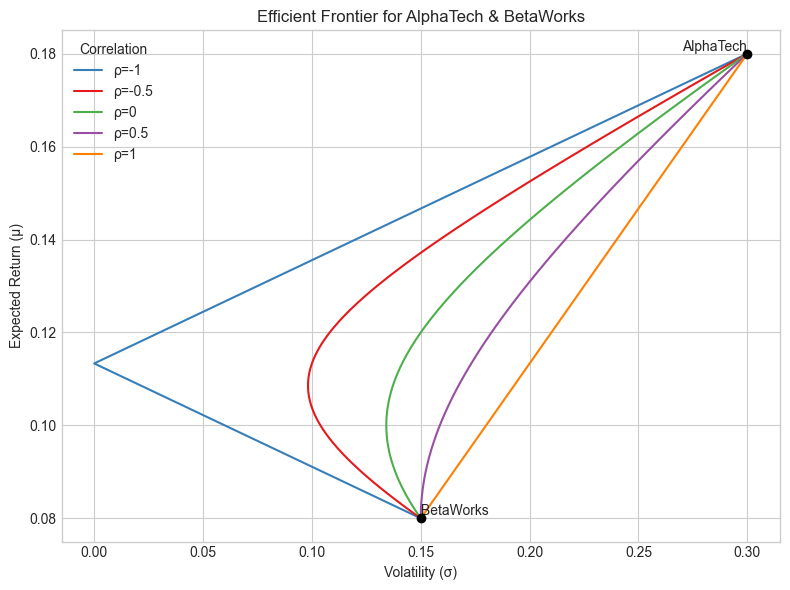

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

# Color‐blind friendly palette (ColorBrewer)
cb_colors = ["#377eb8", "#e41a1c", "#4daf4a", "#984ea3", "#ff7f00"]
plt.rcParams['axes.prop_cycle'] = cycler('color', cb_colors)

# Asset parameters for AlphaTech & BetaWorks
mu_alpha, mu_beta = 0.18, 0.08
sigma_alpha, sigma_beta = 0.30, 0.15

# Correlation scenarios
correlations = [-1, -0.5, 0, 0.5, 1]

# Portfolio weights (fraction in AlphaTech)
weights = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))
for rho in correlations:
    sigma_p = np.sqrt(
        weights**2 * sigma_alpha**2 +
        (1 - weights)**2 * sigma_beta**2 +
        2 * weights * (1 - weights) * rho * sigma_alpha * sigma_beta
    )
    mu_p = weights * mu_alpha + (1 - weights) * mu_beta
    plt.plot(sigma_p, mu_p, label=f'ρ={rho}')

# Plot individual assets
plt.scatter([sigma_beta, sigma_alpha], [mu_beta, mu_alpha], color='black', zorder=5)
plt.text(sigma_alpha, mu_alpha, 'AlphaTech', va='bottom', ha='right')
plt.text(sigma_beta, mu_beta, 'BetaWorks', va='bottom', ha='left')

plt.xlabel('Volatility (σ)')
plt.ylabel('Expected Return (μ)')
plt.title('Efficient Frontier for AlphaTech & BetaWorks')
plt.legend(title='Correlation')
plt.grid(True)
plt.tight_layout()
plt.show()


---

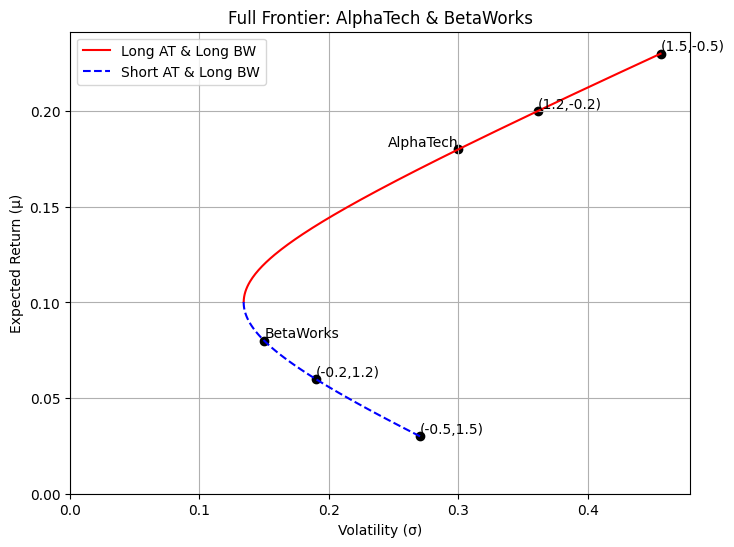

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Asset parameters
mu_alpha, mu_beta = 0.18, 0.08
sigma_alpha, sigma_beta = 0.30, 0.15
rho = 0.0  # zero correlation assumption

# Weight grid from -0.5 (short AT) to 1.5 (levered AT)
w = np.linspace(-0.5, 1.5, 300)

# Portfolio return and volatility
ret = w*mu_alpha + (1-w)*mu_beta
vol = np.sqrt(
    w**2 * sigma_alpha**2 +
    (1-w)**2 * sigma_beta**2 +
    2*w*(1-w)*rho*sigma_alpha*sigma_beta
)

# Find minimum‐variance weight index
idx_min = np.argmin(vol)

plt.figure(figsize=(8,6))

# Long–Long branch (above min‐var)
plt.plot(vol[idx_min:], ret[idx_min:], color='red', label='Long AT & Long BW')
# Short–Long branch (below min‐var)
plt.plot(vol[:idx_min+1], ret[:idx_min+1], '--', color='blue', label='Short AT & Long BW')

# Plot the pure assets
plt.scatter([sigma_beta, sigma_alpha], [mu_beta, mu_alpha], color='black')
plt.text(sigma_alpha, mu_alpha, 'AlphaTech', va='bottom', ha='right')
plt.text(sigma_beta, mu_beta, 'BetaWorks', va='bottom', ha='left')

# Annotate some specific (w,1−w) points
for w0 in [1.2, 1.5, -0.2, -0.5]:
    r0 = w0*mu_alpha + (1-w0)*mu_beta
    v0 = np.sqrt(
        w0**2 * sigma_alpha**2 +
        (1-w0)**2 * sigma_beta**2 +
        2*w0*(1-w0)*rho*sigma_alpha*sigma_beta
    )
    plt.scatter(v0, r0, color='black')
    plt.text(v0, r0, f'({w0:.1f},{1-w0:.1f})', va='bottom')

plt.xlabel('Volatility (σ)')
plt.ylabel('Expected Return (μ)')
plt.title('Full Frontier: AlphaTech & BetaWorks')

# Set both axes to start at zero
plt.xlim(0, vol.max()*1.05)
plt.ylim(0, ret.max()*1.05)

plt.legend()
plt.grid(True)
plt.show()


---

[*********************100%***********************]  10 of 10 completed


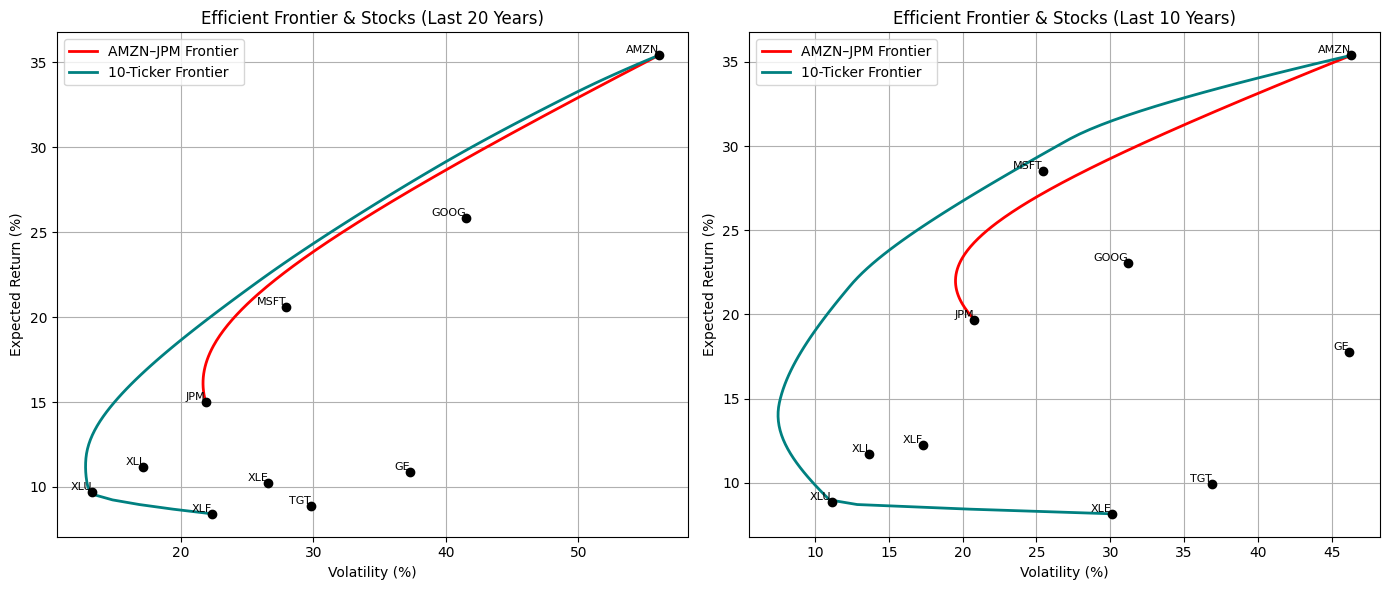

In [31]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 1. Download adjusted close prices for our 10-ticker universe
tickers = ['AMZN', 'GOOG', 'TGT', 'MSFT', 'JPM', 'GE', 'XLE', 'XLF', 'XLI', 'XLU']
data = yf.download(tickers, start='2000-01-01', auto_adjust=True)['Close']

# 2. Compute annual returns (year-end)
annual = data.resample('YE').last().pct_change().dropna()
current_year = pd.Timestamp.today().year
returns20 = annual[annual.index.year >= current_year - 20]
returns10 = annual[annual.index.year >= current_year - 10]

def compute_frontiers(returns, base_pair=('AMZN','JPM'), nsim=500000):
    # statistics
    mu = returns.mean()          # decimal
    cov = returns.cov()          # decimal
    
    # analytic 2-stock frontier for base_pair
    i, j = base_pair
    w2 = np.linspace(0, 1, 200)
    ret2 = w2*mu[i] + (1 - w2)*mu[j]
    vol2 = np.sqrt(
        w2**2 * cov.loc[i,i] +
        (1 - w2)**2 * cov.loc[j,j] +
        2*w2*(1-w2)*cov.loc[i,j]
    )
    
    # SMOOTH 10-ticker frontier using optimization instead of Monte Carlo
    def minimize_vol_for_return(target_return):
        def objective(weights):
            return np.sqrt(np.dot(weights, np.dot(cov.values, weights)))
        
        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w: np.dot(w, mu.values) - target_return}
        ]
        bounds = [(0, 1) for _ in range(len(tickers))]
        
        x0 = np.ones(len(tickers)) / len(tickers)
        result = minimize(objective, x0, method='SLSQP', 
                         bounds=bounds, constraints=constraints)
        return result
    
    # Generate smooth frontier
    min_return = mu.min()
    max_return = mu.max()
    target_returns = np.linspace(min_return, max_return, 100)
    
    front_ret = []
    front_vol = []
    
    for target_ret in target_returns:
        result = minimize_vol_for_return(target_ret)
        if result.success:
            front_ret.append(target_ret)
            front_vol.append(result.fun)
    
    ret6 = np.array(front_ret)
    vol6 = np.array(front_vol)
    
    # also per‐asset stats
    mu_pct   = mu * 100
    sigma_pct = np.sqrt(np.diag(cov)) * 100
    
    return (ret2*100, vol2*100,
            ret6*100, vol6*100,
            mu_pct, sigma_pct)

# compute frontiers for both horizons
ret2_20, vol2_20, ret6_20, vol6_20, mu20, sigma20 = compute_frontiers(returns20)
ret2_10, vol2_10, ret6_10, vol6_10, mu10, sigma10 = compute_frontiers(returns10)

# 3. Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Slide 1: Last 20 years
ax = axes[0]
ax.plot(vol2_20, ret2_20, color='red',   lw=2, label='AMZN–JPM Frontier')
ax.plot(vol6_20, ret6_20, color='teal',  lw=2, label='10-Ticker Frontier')
ax.scatter(sigma20, mu20, color='black', zorder=5)
for t, x, y in zip(mu20.index, sigma20, mu20):
    ax.text(x, y, t, fontsize=8, va='bottom', ha='right')
ax.set_title('Efficient Frontier & Stocks (Last 20 Years)')
ax.set_xlabel('Volatility (%)')
ax.set_ylabel('Expected Return (%)')
ax.legend()
ax.grid(True)

# Slide 2: Last 10 years
ax = axes[1]
ax.plot(vol2_10, ret2_10, color='red',   lw=2, label='AMZN–JPM Frontier')
ax.plot(vol6_10, ret6_10, color='teal',  lw=2, label='10-Ticker Frontier')
ax.scatter(sigma10, mu10, color='black', zorder=5)
for t, x, y in zip(mu10.index, sigma10, mu10):
    ax.text(x, y, t, fontsize=8, va='bottom', ha='right')
ax.set_title('Efficient Frontier & Stocks (Last 10 Years)')
ax.set_xlabel('Volatility (%)')
ax.set_ylabel('Expected Return (%)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

---

### Capital Allocation to Risk-free and Risky Assets

* The ability to choose the amount to invest in risky versus risk-free securities allows us to determine the optimal portfolio of risky securities for an investor.

* The Complete portfolio consists of the risky asset and the risk-free asset.
    * A portfolio risk closer to the desired level can be achieved by changing the weights of risk-free asset and risky assets in the complete portfolio.

    $ w_{rf} + w_P = 1 $

    $ w_{rf} = 1 - w_P $

    $ E(r_C) = (1 - w_P) \cdot r_f + w_P \cdot E(r_P) $

    $ E(r_C) = r_f + w_P \cdot [E(r_P) - r_f] $

    $ \sigma_C^2 = w_{rf}^2 \sigma_{rf}^2 + w_P^2 \sigma_P^2 + 2 \cdot w_{rf} w_P \text{Cov}(r_f, r_P) $

    Since $ \sigma_{rf}^2 = 0 $ and $ \text{Cov}(r_f, r_P) = 0 \quad \Rightarrow \quad \sigma_C^2 = w_P^2 \sigma_P^2 $

---

### Capital Allocation to Risk-free and Risky Assets

Suppose you have \$10,000 in cash, and you want to invest both in a risk-free asset that earns 5% and a risky portfolio which has a 10% expected return and a 20% volatility. You decide that your overall portfolio should not have an expected volatility more than 15%. To maximize your expected return:

Target $\sigma(R_p)=15\%$, with $E[R_{\text{risky}}]=10\%$, $\sigma(R_{\text{risky}})=20\%$, and $r_f=5\%$.

$\sigma(R_p)=w_{\text{risky}}\;\sigma(R_{\text{risky}})$

$15\%=w_{\text{risky}}\times20\%\quad\Longrightarrow\quad w_{\text{risky}}=75\%$

$w_{f}=1-w_{\text{risky}}=25\%$
  
$E[R_p] =r_f + w_{\text{risky}}\bigl(E[R_{\text{risky}}]-r_f\bigr) =5\% + 75\%\times(10\%-5\%) =8.75\% $
  
---

### Capital Allocation to Risk-free and Risky Assets

Suppose you have \$15,000 in cash, and you decide to borrow another \$10,000 at a 3\% interest rate to invest \$25,000 in Portfolio Sigma, which has a 12\% expected return and an 18\% volatility.  
  * Initial equity = \$15,000; Invested in Sigma = \$25,000; Borrowed = \$10,000.  
  
  * Weight in Sigma: $\quad w_{\Sigma}=\frac{25000}{15000}=166.67\%$  
  
  * Weight in risk‐free (borrowing): $\quad w_f=\frac{-10000}{15000}=-66.67\%$  
  
  $E[R_{\Sigma}]=12\%$, $\sigma(R_{\Sigma})=18\%$, $r_f=3\%$.

  $E[R_p] =r_f + w_{\Sigma}\bigl(E[R_{\Sigma}]-r_f\bigr) =3\% + 166.67\%\times(12\%-3\%) =18\% $

  $\sigma(R_p) =\lvert w_{\Sigma}\rvert\,\sigma(R_{\Sigma}) =166.67\%\times18\% =30\% $

  $R_p =w_f\,r_f + w_{\Sigma}\,R_{\Sigma} =-66.67\%\times3\% + 166.67\%\times R_{\Sigma}$
  
  If $R_{\Sigma}=20\%$: $\quad R_p^U =-2\% + 1.6667\times20\% =31.33\% $
  
  If $R_{\Sigma}=-15\%$: $\quad R_p^D =-2\% + 1.6667\times(-15\%) =-27\% $
  
---

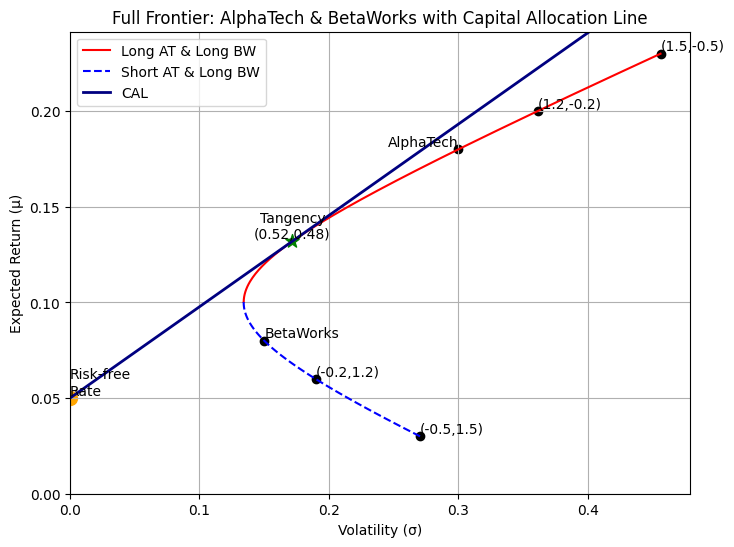

Risk-free rate: 5.0%
Tangency portfolio weights: AlphaTech = 0.52, BetaWorks = 0.48
Tangency portfolio return: 13.2%
Tangency portfolio volatility: 17.2%
Sharpe ratio of tangency portfolio: 0.477


In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Asset parameters
mu_alpha, mu_beta = 0.18, 0.08
sigma_alpha, sigma_beta = 0.30, 0.15
rho = 0.0  # zero correlation assumption
r_f = 0.05  # risk-free rate (5%)

# Weight grid from -0.5 (short AT) to 1.5 (levered AT)
w = np.linspace(-0.5, 1.5, 300)

# Portfolio return and volatility
ret = w*mu_alpha + (1-w)*mu_beta
vol = np.sqrt(
    w**2 * sigma_alpha**2 +
    (1-w)**2 * sigma_beta**2 +
    2*w*(1-w)*rho*sigma_alpha*sigma_beta
)

# Find minimum‐variance weight index
idx_min = np.argmin(vol)

# Find tangency portfolio weight
# For two assets with zero correlation, tangency weight is:
# w_tan = (mu_alpha - r_f) * sigma_beta^2 - (mu_beta - r_f) * sigma_alpha * sigma_beta * rho
#         / [(mu_alpha - r_f) * sigma_beta^2 + (mu_beta - r_f) * sigma_alpha^2 - (mu_alpha + mu_beta - 2*r_f) * sigma_alpha * sigma_beta * rho]
# Since rho = 0, this simplifies to:
w_tan = ((mu_alpha - r_f) * sigma_beta**2) / ((mu_alpha - r_f) * sigma_beta**2 + (mu_beta - r_f) * sigma_alpha**2)

# Tangency portfolio return and volatility
ret_tan = w_tan * mu_alpha + (1 - w_tan) * mu_beta
vol_tan = np.sqrt(w_tan**2 * sigma_alpha**2 + (1 - w_tan)**2 * sigma_beta**2)

plt.figure(figsize=(8,6))

# Long–Long branch (above min‐var)
plt.plot(vol[idx_min:], ret[idx_min:], color='red', label='Long AT & Long BW')

# Short–Long branch (below min‐var)
plt.plot(vol[:idx_min+1], ret[:idx_min+1], '--', color='blue', label='Short AT & Long BW')

# Plot the pure assets
plt.scatter([sigma_beta, sigma_alpha], [mu_beta, mu_alpha], color='black')
plt.text(sigma_alpha, mu_alpha, 'AlphaTech', va='bottom', ha='right')
plt.text(sigma_beta, mu_beta, 'BetaWorks', va='bottom', ha='left')

# Plot tangency portfolio
plt.scatter(vol_tan, ret_tan, color='green', s=100, marker='*')
plt.text(vol_tan, ret_tan, f'Tangency\n({w_tan:.2f},{1-w_tan:.2f})', va='bottom', ha='center')

# Draw Capital Allocation Line (CAL)
# Extend line from risk-free rate through tangency portfolio
vol_cal = np.linspace(0, vol.max()*1.05, 100)
ret_cal = r_f + (ret_tan - r_f) / vol_tan * vol_cal
plt.plot(vol_cal, ret_cal, color='navy', linewidth=2, label='CAL')

# Plot risk-free rate
plt.scatter(0, r_f, color='orange', s=100)
plt.text(0, r_f, 'Risk-free\nRate', va='bottom', ha='left')

# Annotate some specific (w,1−w) points
for w0 in [1.2, 1.5, -0.2, -0.5]:
    r0 = w0*mu_alpha + (1-w0)*mu_beta
    v0 = np.sqrt(
        w0**2 * sigma_alpha**2 +
        (1-w0)**2 * sigma_beta**2 +
        2*w0*(1-w0)*rho*sigma_alpha*sigma_beta
    )
    plt.scatter(v0, r0, color='black')
    plt.text(v0, r0, f'({w0:.1f},{1-w0:.1f})', va='bottom')

plt.xlabel('Volatility (σ)')
plt.ylabel('Expected Return (μ)')
plt.title('Full Frontier: AlphaTech & BetaWorks with Capital Allocation Line')

# Set both axes to start at zero
plt.xlim(0, vol.max()*1.05)
plt.ylim(0, ret.max()*1.05)
plt.legend()
plt.grid(True)
plt.show()

print(f"Risk-free rate: {r_f:.1%}")
print(f"Tangency portfolio weights: AlphaTech = {w_tan:.2f}, BetaWorks = {1-w_tan:.2f}")
print(f"Tangency portfolio return: {ret_tan:.1%}")
print(f"Tangency portfolio volatility: {vol_tan:.1%}")
print(f"Sharpe ratio of tangency portfolio: {(ret_tan - r_f)/vol_tan:.3f}")

---

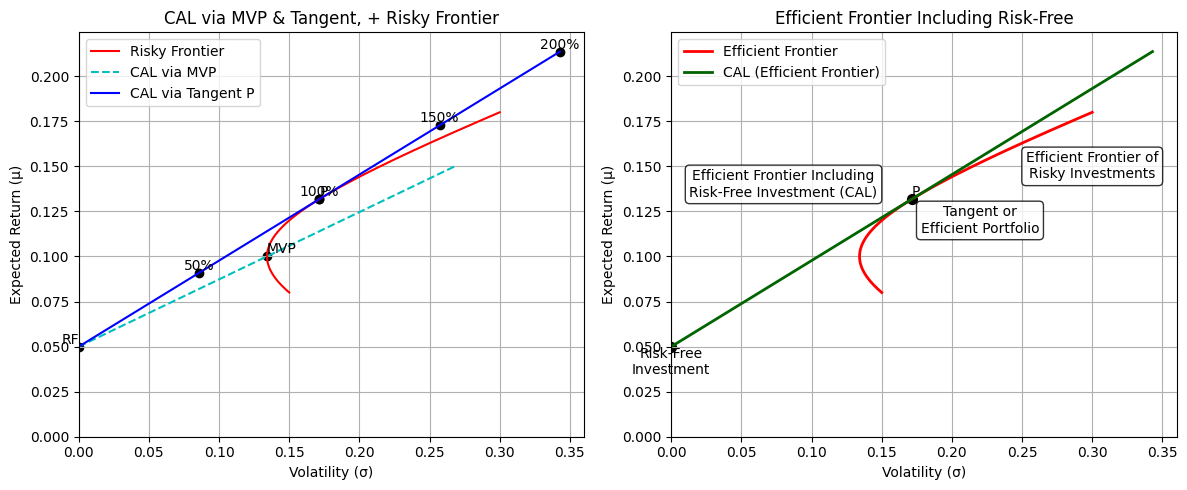

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mu_alpha, mu_beta = 0.18, 0.08
sigma_alpha, sigma_beta = 0.30, 0.15
rho = 0.0
r_f = 0.05

# Risky frontier (0–100% weights)
w = np.linspace(0, 1, 300)
ret = w*mu_alpha + (1-w)*mu_beta
vol = np.sqrt(w**2 * sigma_alpha**2 +
              (1-w)**2 * sigma_beta**2 +
              2*w*(1-w)*rho*sigma_alpha*sigma_beta)

# Minimum‐variance portfolio
idx_mvp = np.argmin(vol)
vol_mvp, ret_mvp = vol[idx_mvp], ret[idx_mvp]

# Tangent (max Sharpe) portfolio
sharpe = (ret - r_f) / vol
idx_tan = np.argmax(sharpe)
vol_tan, ret_tan = vol[idx_tan], ret[idx_tan]

# CAL via MVP (extend to 200% risky)
w_m = np.linspace(0, 2, 300)
vol_cal_m = w_m * vol_mvp
ret_cal_m = r_f + w_m * (ret_mvp - r_f)

# CAL via Tangent P (extend to 200% risky)
w_t = np.linspace(0, 2, 300)
vol_cal_t = w_t * vol_tan
ret_cal_t = r_f + w_t * (ret_tan - r_f)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Left: both CALs + risky frontier
ax = axes[0]
ax.plot(vol, ret, 'r-', label='Risky Frontier')
ax.plot(vol_cal_m, ret_cal_m, 'c--', label='CAL via MVP')
ax.plot(vol_cal_t, ret_cal_t, 'b-', label='CAL via Tangent P')
ax.scatter(0, r_f, c='k'); ax.text(0, r_f, 'RF', va='bottom', ha='right')
ax.scatter(vol_mvp, ret_mvp, c='k'); ax.text(vol_mvp, ret_mvp, 'MVP', va='bottom', ha='left')
ax.scatter(vol_tan, ret_tan, c='k'); ax.text(vol_tan, ret_tan, 'P', va='bottom', ha='left')
for w0,lbl in zip([0.5,1,1.5,2], ['50%','100%','150%','200%']):
    x = w0*vol_tan; y = r_f + w0*(ret_tan - r_f)
    ax.scatter(x,y,c='k'); ax.text(x,y,lbl, va='bottom', ha='center')
ax.set_xlim(0, vol_cal_t.max()*1.05)
ax.set_ylim(0, ret_cal_t.max()*1.05)
ax.set_xlabel('Volatility (σ)')
ax.set_ylabel('Expected Return (μ)')
ax.set_title('CAL via MVP & Tangent, + Risky Frontier')
ax.legend(); ax.grid(True)

# Right: efficient frontier + tangent CAL
ax = axes[1]
# Use the full risky frontier to match the left graph
ax.plot(vol, ret, 'r-', linewidth=2, label='Efficient Frontier')
ax.plot(vol_cal_t, ret_cal_t, 'darkgreen', linewidth=2, label='CAL (Efficient Frontier)')
ax.scatter(0, r_f, c='k', s=50); ax.text(0, r_f, 'Risk-Free\nInvestment', va='top', ha='center')
ax.scatter(vol_tan, ret_tan, c='k', s=50); ax.text(vol_tan, ret_tan, 'P', va='bottom', ha='left')

# Add the three main labels as shown in the reference image
ax.text(0.08, 0.14, 'Efficient Frontier Including\nRisk-Free Investment (CAL)', ha='center', va='center', 
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
ax.text(0.22, 0.12, 'Tangent or\nEfficient Portfolio', ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
ax.text(0.30, 0.15, 'Efficient Frontier of\nRisky Investments', ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

ax.set_xlim(0, vol_cal_t.max()*1.05)
ax.set_ylim(0, ret_cal_t.max()*1.05)
ax.set_xlabel('Volatility (σ)')
ax.set_ylabel('Expected Return (μ)')
ax.set_title('Efficient Frontier Including Risk-Free')
ax.legend(); ax.grid(True)

plt.tight_layout()
plt.show()

---

### Capital Allocation to Risk-Free and Risky Assets

* The tangent portfolio is the portfolio of risky assets with the highest possible Sharpe Ratio. 

* Combining the risk-free asset with the tangent portfolio provides the best risk-return tradeoff (Capital Market Line - CML).

**Sharpe Ratio**  
$$ \text{Sharpe Ratio (SR)} = \frac{E[R_p] - r_f}{\sigma(R_p)} $$  
- Excess return per unit of total risk.  
- Higher SR ⇒ more reward for each unit of volatility.

**Tangent Portfolio & the Complete Portfolio**  
- Let \(P\) be the tangent portfolio of risky assets (the one with the highest SR).  
- A complete portfolio, \(C\), mixes the risk-free asset and \(P\).  
  $$ E[R_C] = r_f + \underbrace{\frac{E[R_P] - r_f}{\sigma_P}}_{SR_P} \;\sigma_C$$  

- All investors combine the risk-free asset with the same tangent portfolio \(P\), regardless of risk aversion.  
- More conservative ⇒ choose a lower $\sigma_C$ (hold more in cash).  
- More aggressive ⇒ choose a higher $\sigma_C$ (borrow to lever up \(P\)).  

--- 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import warnings

# --- Input Parameter Widgets ---
style_desc = {'description_width': '230px'}
input_field_layout = widgets.Layout(width='120px')
widget_layout_left = widgets.Layout(width='370px') # Keep these for input section
widget_layout_right = widgets.Layout(width='370px')

er_a_widget = widgets.FloatText(value=0.10, step=0.001, description='Exp. Return Asset A E(rA):', style=style_desc, layout=widget_layout_left)
std_a_widget = widgets.FloatText(value=0.15, step=0.001, description='Std. Dev. Asset A (σA):', style=style_desc, layout=widget_layout_left)
er_b_widget = widgets.FloatText(value=0.18, step=0.001, description='Exp. Return Asset B E(rB):', style=style_desc, layout=widget_layout_right)
std_b_widget = widgets.FloatText(value=0.25, step=0.001, description='Std. Dev. Asset B (σB):', style=style_desc, layout=widget_layout_right)
corr_ab_widget = widgets.FloatText(value=0.20, step=0.01, min=-1, max=1, description='Correlation (ρAB):', style=style_desc, layout=widget_layout_left)
cov_ab_widget = widgets.FloatText(value=0.0075, step=0.0001, description='Covariance (Cov(rA,rB)):', style=style_desc, layout=widget_layout_left)
rf_widget = widgets.FloatText(value=0.03, step=0.001, description='Risk-Free Rate (rf):', style=style_desc, layout=widget_layout_left)

# --- Output Widgets ---
output_portfolios_info = widgets.Output()
# For side-by-side display, these will be placed in an HBox
output_table_cal = widgets.Output(layout=widgets.Layout(width='40%', min_width='380px', overflow_x='auto', padding='5px'))
output_plot = widgets.Output(layout=widgets.Layout(width='60%', min_width='500px', padding='5px'))

# --- Recalculate Button ---
recalculate_button = widgets.Button(
    description="Recalculate & Plot", button_style='info', icon='refresh',
    layout=widgets.Layout(width='auto', min_width='180px', margin='10px 0 0 0')
)

# --- Linking Logic for Correlation and Covariance ---
updating_internally = False
def format_float_widget_value(widget, value, precision):
    try:
        actual_value_to_set = 0.0 if pd.isna(value) else float(f"{value:.{precision}f}")
        current_widget_val = widget.value
        if current_widget_val is None or abs(current_widget_val - actual_value_to_set) > 10**-(precision+1):
            widget.value = actual_value_to_set
    except Exception: pass

def update_covariance_from_corr(change):
    global updating_internally;
    if updating_internally: return
    updating_internally = True
    try:
        if std_a_widget.value is not None and std_b_widget.value is not None and corr_ab_widget.value is not None:
            new_cov = corr_ab_widget.value * std_a_widget.value * std_b_widget.value
            format_float_widget_value(cov_ab_widget, new_cov, 6)
    finally: updating_internally = False

def update_correlation_from_cov(change):
    global updating_internally;
    if updating_internally: return
    updating_internally = True
    try:
        if std_a_widget.value is not None and std_b_widget.value is not None and cov_ab_widget.value is not None:
            if std_a_widget.value > 1e-9 and std_b_widget.value > 1e-9:
                corr_val = cov_ab_widget.value / (std_a_widget.value * std_b_widget.value)
                format_float_widget_value(corr_ab_widget, np.clip(corr_val, -1, 1), 4)
            else: format_float_widget_value(corr_ab_widget, np.nan, 4)
    finally: updating_internally = False

corr_ab_widget.observe(update_covariance_from_corr, names='value')
cov_ab_widget.observe(update_correlation_from_cov, names='value')
std_a_widget.observe(update_covariance_from_corr, names='value')
std_b_widget.observe(update_covariance_from_corr, names='value')

# --- Core Calculation and Plotting Logic ---
def calculate_and_display_all(b=None):
    with output_portfolios_info: clear_output(wait=True)
    with output_table_cal: clear_output(wait=True)
    with output_plot: clear_output(wait=True)
    try:
        er_a = er_a_widget.value; std_a = std_a_widget.value; var_a = std_a**2 if std_a is not None else None
        er_b = er_b_widget.value; std_b = std_b_widget.value; var_b = std_b**2 if std_b is not None else None
        cov_ab = cov_ab_widget.value
        rf = rf_widget.value

        if any(v is None for v in [er_a, std_a, er_b, std_b, cov_ab, rf]):
            with output_plot: display(HTML("<p style='color:red;'>Error: One or more input values are missing.</p>"))
            return
        if std_a <= 1e-9 or std_b <= 1e-9 :
            with output_plot: display(HTML("<p style='color:red;'>Error: Standard deviations of risky assets must be greater than 0.</p>"))
            return

        plot_weights_a_mvf = np.linspace(-0.5, 1.5, 200)
        plot_returns_mvf = np.array([w_a * er_a + (1 - w_a) * er_b for w_a in plot_weights_a_mvf])
        plot_vars_mvf = np.array([(w_a**2 * var_a) + ((1 - w_a)**2 * var_b) + (2 * w_a * (1 - w_a) * cov_ab) for w_a in plot_weights_a_mvf])
        plot_vars_mvf = np.maximum(0, plot_vars_mvf)
        plot_stds_mvf = np.sqrt(plot_vars_mvf)

        denominator_gmvp = var_a + var_b - 2 * cov_ab
        w_a_gmvp = (var_b - cov_ab) / denominator_gmvp if abs(denominator_gmvp) > 1e-9 else 0.5
        w_b_gmvp = 1 - w_a_gmvp
        gmvp_return = w_a_gmvp * er_a + w_b_gmvp * er_b
        gmvp_var = (w_a_gmvp**2 * var_a) + (w_b_gmvp**2 * var_b) + (2 * w_a_gmvp * w_b_gmvp * cov_ab)
        gmvp_var = max(0, gmvp_var)
        gmvp_std = np.sqrt(gmvp_var)
        gmvp_sharpe = (gmvp_return - rf) / gmvp_std if gmvp_std > 1e-9 else np.nan

        sorted_mvf_indices = np.argsort(plot_stds_mvf)
        sorted_stds_mvf = plot_stds_mvf[sorted_mvf_indices]
        sorted_returns_mvf = plot_returns_mvf[sorted_mvf_indices]
        gmvp_idx_on_sorted_mvf = np.argmin(sorted_stds_mvf)
        stds_ef = sorted_stds_mvf[gmvp_idx_on_sorted_mvf:]
        returns_ef = sorted_returns_mvf[gmvp_idx_on_sorted_mvf:]
        final_stds_ef = [stds_ef[0]] if len(stds_ef)>0 else []
        final_returns_ef = [returns_ef[0]] if len(returns_ef)>0 else []
        if len(stds_ef) > 0:
            for k_ef in range(1, len(stds_ef)):
                if returns_ef[k_ef] >= final_returns_ef[-1] - 1e-6:
                    final_stds_ef.append(stds_ef[k_ef])
                    final_returns_ef.append(returns_ef[k_ef])

        ex_ret_a = er_a - rf
        ex_ret_b = er_b - rf
        num_w_a_orp = ex_ret_a * var_b - ex_ret_b * cov_ab
        den_w_a_orp = ex_ret_a * var_b + ex_ret_b * var_a - (ex_ret_a + ex_ret_b) * cov_ab
        w_a_orp = num_w_a_orp / den_w_a_orp if abs(den_w_a_orp) > 1e-9 else 0.5
        w_b_orp = 1 - w_a_orp
        orp_return = w_a_orp * er_a + w_b_orp * er_b
        orp_var = (w_a_orp**2 * var_a) + (w_b_orp**2 * var_b) + (2 * w_a_orp * w_b_orp * cov_ab)
        orp_var = max(0, orp_var)
        orp_std = np.sqrt(orp_var)
        orp_sharpe = (orp_return - rf) / orp_std if orp_std > 1e-9 else np.nan

        with output_portfolios_info:
            display(HTML("<h4>Characteristic Portfolios:</h4>"))
            info_data = {
                'Portfolio': ['GMVP (A&B)', 'Optimal Risky (ORP)'],
                'Weight Asset A': [f"{w_a_gmvp*100:.2f}%", f"{w_a_orp*100:.2f}%"],
                'Weight Asset B': [f"{w_b_gmvp*100:.2f}%", f"{w_b_orp*100:.2f}%"],
                'Exp. Return': [f"{gmvp_return*100:.2f}%", f"{orp_return*100:.2f}%"],
                'Std. Dev.': [f"{gmvp_std*100:.2f}%", f"{orp_std*100:.2f}%"],
                'Sharpe Ratio': [
                    f"{gmvp_sharpe:.4f}" if not pd.isna(gmvp_sharpe) else "N/A",
                    f"{orp_sharpe:.4f}" if not pd.isna(orp_sharpe) else "N/A"
                ]
            }
            display(pd.DataFrame(info_data))

        plot_weights_orp_cal = np.linspace(0, 1.5, 100)
        cal_returns = np.array([w_orp * orp_return + (1 - w_orp) * rf for w_orp in plot_weights_orp_cal])
        cal_stds = np.array([w_orp * orp_std for w_orp in plot_weights_orp_cal])
        table_weights_orp = np.array([0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
        table_cal_data = []
        # Concise column headers for the CAL table
        cal_table_cols = ["w_RF (%)", "w_ORP (%)", "E(r<sub>C</sub>) (%)", "σ<sub>C</sub> (%)", "Sharpe (CAL)"]
        for w_orp_t in table_weights_orp:
            w_rf_t = 1 - w_orp_t
            rc_t = w_orp_t * orp_return + w_rf_t * rf
            stdc_t = w_orp_t * orp_std
            sharpe_cal_t = (rc_t - rf) / stdc_t if stdc_t > 1e-9 else np.nan
            table_cal_data.append([
                f"{w_rf_t*100:.0f}", f"{w_orp_t*100:.0f}", # Removed % for better fit if needed
                f"{rc_t*100:.2f}", f"{stdc_t*100:.2f}",
                f"{sharpe_cal_t:.4f}" if not pd.isna(sharpe_cal_t) else "N/A"
            ])
        df_cal_table = pd.DataFrame(table_cal_data, columns=cal_table_cols)
        with output_table_cal:
            display(HTML("<h4>Capital Allocation Line (CAL) Combinations (Risk-Free + ORP):</h4>"))
            # Render DataFrame as HTML to allow for potential future styling
            # For now, default rendering is used.
            display(HTML(df_cal_table.to_html(escape=False, index=False)))


        with output_plot:
            fig, ax = plt.subplots(figsize=(9, 6.5)) # Adjusted figsize for side-by-side
            ax.plot(plot_stds_mvf, plot_returns_mvf, linestyle='--', color='gray', label='Min. Var. Frontier (A&B)')
            if final_stds_ef:
                 ax.plot(final_stds_ef, final_returns_ef, linestyle='-', color='blue', linewidth=2, label='Efficient Frontier (A&B)')
            ax.plot(cal_stds, cal_returns, linestyle='-', color='green', linewidth=2.5, label='Capital Allocation Line (CAL)', zorder=3)
            ax.scatter([0], [rf], color='darkorange', marker='o', s=120, label=f'Risk-Free Asset (rf = {rf*100:.2f}%)', zorder=5, edgecolors='black')
            ax.scatter([std_a], [er_a], color='red', marker='s', s=100, label='Asset A', zorder=4, edgecolors='black')
            ax.scatter([std_b], [er_b], color='purple', marker='s', s=100, label='Asset B', zorder=4, edgecolors='black')
            ax.scatter([gmvp_std], [gmvp_return], color='cyan', marker='P', s=150, label='GMVP (A&B)', zorder=5, edgecolors='black')
            ax.scatter([orp_std], [orp_return], color='magenta', marker='D', s=150, label='Optimal Risky Portfolio (ORP)', zorder=6, edgecolors='black')
            ax.set_title('Efficient Frontier, ORP & CAL', fontsize=14) # Shortened title
            ax.set_xlabel('Portfolio Standard Deviation (σ)', fontsize=12)
            ax.set_ylabel('Portfolio Expected Return (E(r))', fontsize=12)
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.1f}%'))
            
            current_max_std = max(np.max(plot_stds_mvf) if plot_stds_mvf.size > 0 else 0.1,
                                  np.max(cal_stds) if cal_stds.size > 0 else 0.1,
                                  std_a if std_a is not None else 0, 
                                  std_b if std_b is not None else 0, 0.1) * 1.1
            current_max_ret = max(np.max(plot_returns_mvf) if plot_returns_mvf.size > 0 else (rf if rf is not None else 0),
                                  np.max(cal_returns) if cal_returns.size > 0 else (rf if rf is not None else 0)
                                 ) * 1.1
            current_max_ret = max(current_max_ret, (rf if rf is not None else 0) + 0.01) # Ensure y-axis accommodates points

            ax.set_xlim(-0.01, current_max_std)
            ax.set_ylim(0, current_max_ret) # Y-axis minimum set to 0

            ax.legend(loc='best', fontsize=9)
            ax.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()
    except Exception as e:
        error_html = f"<p style='color:red;'>An error occurred: {e}<br>Check input values, especially for division by zero, NaN, or invalid math operations.</p>"
        with output_portfolios_info: clear_output(wait=True); display(HTML(error_html))
        with output_table_cal: clear_output(wait=True)
        with output_plot: clear_output(wait=True)


# --- Linking Button and Initial Display ---
recalculate_button.on_click(calculate_and_display_all)

# Arrange UI
title_widget = widgets.HTML("<h2>Efficient Frontier, Optimal Risky Portfolio & CAL</h2>", layout=widgets.Layout(width='100%'))
formula_var_p = widgets.HTML("Portfolio Variance (2 assets): σ²<sub>p</sub> = w²<sub>A</sub>σ²<sub>A</sub> + w²<sub>B</sub>σ²<sub>B</sub> + 2w<sub>A</sub>w<sub>B</sub>Cov(A,B)", layout=widgets.Layout(margin='5px 0 2px 0'))
formula_cal = widgets.HTML("CAL: E(r<sub>C</sub>) = r<sub>f</sub> + [(E(r<sub>ORP</sub>) - r<sub>f</sub>) / σ<sub>ORP</sub>] σ<sub>C</sub>", layout=widgets.Layout(margin='0 0 15px 0'))
inputs_col_left = widgets.VBox([er_a_widget, std_a_widget, corr_ab_widget, cov_ab_widget, rf_widget])
inputs_col_right = widgets.VBox([er_b_widget, std_b_widget])
recalc_button_box = widgets.HBox([recalculate_button], layout=widgets.Layout(justify_content='center', margin='10px 0 0 0'))
input_ui_grid = widgets.HBox([inputs_col_left, inputs_col_right])

# New HBox for side-by-side table and plot
output_section_main = widgets.HBox([output_table_cal, output_plot])

full_ui = widgets.VBox([
    title_widget,
    formula_var_p,
    formula_cal,
    input_ui_grid,
    recalc_button_box,
    output_portfolios_info, # Characteristic portfolios table remains above
    widgets.HTML("<hr>"),
    output_section_main,    # HBox containing CAL table and Plot
    # widgets.HTML("<hr>"), # Optional: remove this if no more content below the HBox
    # output_plot # This is now inside output_section_main
])

with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    update_covariance_from_corr(None)
    display(full_ui)
    calculate_and_display_all()

---

### Capital Allocation to Risk-Free and Risky Assets

A client's current portfolio is valued at $500,000 and has an expected return of 11% with a volatility of 15%. You have identified that the optimal risky portfolio has an expected return of 17% and a volatility of 20%. The current risk-free rate is 4%.

*   To maximize the client's expected return without exceeding their current volatility of 15%, what new portfolio allocation would you recommend? What is the expected return of this new portfolio?
*   If the client wishes to maintain their expected return of 11% but minimize their risk, what new portfolio allocation would you recommend? What is the volatility of this new portfolio?

    ---
Let the client's current portfolio be $P$, and the optimal risky portfolio be $T$.

*   **Find the weight:** $\quad  \sigma_{new} = w_T \sigma_T \quad \Rightarrow \quad 15\% = w_T \times 20\% \implies w_T = \frac{15}{20} = 0.75 $

*   **Calculate the new Expected Return:** $\quad E[R_{new}] = r_f + w_T (E[R_T] - r_f) \quad \Rightarrow \quad E[R_{new}] = 4\% + 0.75 \times (17\% - 4\%) = 13.75\% $
    
*A portfolio with 75% in the optimal risky portfolio and 25% in the risk-free asset will achieve an expected return of 13.75% with the same 15% volatility.*

**Minimize Risk for a Given Expected Return**

Ccreate a new portfolio with $E[R_{new}] = 11\%$ that has the lowest possible risk. 

*   **Find the weight:** $\quad E[R_{new}] = r_f + w_T (E[R_T] - r_f)  \quad \Rightarrow \quad 11\% = 4\% + w_T \times (17\% - 4\%) \quad \Rightarrow \quad w_T \approx 0.5385 $

*   **Calculate the new Volatility:** $\quad \sigma_{new} = w_T \sigma_T \quad \Rightarrow \quad \sigma_{new} = 0.5385 \times 20\% \approx 10.77\% $

*A portfolio with 53.85% in the optimal risky portfolio and 46.15% in the risk-free asset will have a volatility of only **10.77%** while still achieving the 11% expected return.*

--- 


### The Capital Asset Pricing Model (CAPM)

**Portfolio Theory vs. CAPM**
*   **Mean-Variance Analysis (Portfolio Theory):**
    *   Tells us how an investor can select an optimal risky portfolio (the tangency portfolio) given expected returns, variances, and covariances.
    *   It's a model of how to choose portfolios but doesn't determine what equilibrium asset prices or expected returns should be.
*   **CAPM:**
    *   An equilibrium model that characterizes the risk-return combinations of securities that must hold if all investors are mean-variance optimizers and markets are in equilibrium.
    *   Equilibrium implies no investor wishes to change their strategy, and all assets are held (markets clear).
    *   If everyone holds an efficient portfolio, what must asset prices (and thus expected returns) be?

*   Modern Portfolio Theory states that all investors, regardless of risk aversion, will choose to hold a combination of just two portfolios:
    *   The risk-free asset
    *   The same optimal risky portfolio (the tangency portfolio)
*   In market equilibrium, if all investors hold this same tangency portfolio of risky assets, then this portfolio must, in aggregate, be the market portfolio.
    *   The market portfolio consists of all risky assets (stocks, bonds, real estate, human capital, etc.) held in proportion to their total market value.
*   The market portfolio is the truly efficient risky portfolio, and its risk premium becomes the benchmark for pricing all other risky assets.

---

### The Capital Asset Pricing Model (CAPM)

**The CAPM Assumptions**
*   All investors are rational mean-variance optimizers with identical planning horizons.
*   Investors can borrow or lend unlimited amounts at a fixed risk-free rate ($r_f$).
*   Markets are perfectly competitive: no individual investor can influence security prices.
*   All assets are tradable and perfectly divisible.
*   No taxes, transaction costs, or restrictions on short selling.
*   Investors have homogeneous expectations. 
    * They agree on the estimates of expected returns, variances, and covariances for all assets.

**The CAPM: Main Result**

The expected return on any security $i$, $E(R_i)$, is determined by:
$$ E[R_i] = r_f + \beta_i \times (E[R_{Mkt}] - r_f) \quad \Rightarrow \quad \beta_i (E(R_{Mkt}) - r_f) = \text{Risk premium for security i}$$
Where:
*   $E(R_{Mkt})$ = Expected return of the market portfolio
*   $E(R_{Mkt}) - r_f$ = Market Risk Premium (MRP)
*   $\beta_i$ = Beta of security $i$

**Beta ($\beta_i$)**
Beta measures the systematic risk of security $i$:
$$ \beta_i = \frac{\text{Cov}(R_i, R_{Mkt})}{\text{Var}(R_{Mkt})} = \frac{\sigma_i \rho_{i,Mkt}}{\sigma_{Mkt}} $$

---

### Security Market Line (SML)
* The CAPM states that all assets must be on the SML. $ \qquad E(R_i) = r_f + \beta_i (E(R_{Mkt}) - r_f) $

**SML**
* Linear relationship between an asset's beta and its required/expected return; every security / portfolio lies on the SML.
* Shows systematic risk only

**CML**
* Linear relationship between total risk and expected return; only two securities lie on the CML (risk-free asset and the market portfolio).
* Shows the total risk (systematic + unsystematic)   

<center>
<img src="../figures/sml.png" width="540"/>
</center>

---

### The Capital Asset Pricing Model (CAPM)

An analyst is assessing a portfolio composed of two stocks: Consolidated Edison (a utility company) with a beta of 0.40, and Nvidia (a tech company) with a beta of 1.60. The risk-free rate is 3%, and the expected return on the market portfolio is 9%.

*   What is the expected return of an equally weighted portfolio of these two stocks?
*   What is the beta of this equally weighted portfolio?

Let $R_C$ be the return for Consolidated Edison and $R_N$ be the return for Nvidia.

**Calculate the Expected Return of the Portfolio**

$E[R_i] = r_f + \beta_i(E[R_M] - r_f)$.

$ E[R_C] = 3\% + 0.40 \times (9\% - 3\%) = 3\% + 2.4\% = 5.4\% \quad \text{and} \quad E[R_N] = 3\% + 1.60 \times (9\% - 3\%) = 3\% + 9.6\% = 12.6\% $

$w_C = 0.5, w_N = 0.5 \quad \Rightarrow E[R_P] = w_C E[R_C] + w_N E[R_N] = (0.50 \times 5.4\%) + (0.50 \times 12.6\%) = 9.0\% $

**Calculate the Beta of the Portfolio**

The portfolio beta is the weighted average of the individual stock betas.

$ \beta_P = w_C \beta_C + w_N \beta_N \quad \Rightarrow \quad \beta_P = (0.50 \times 0.40) + (0.50 \times 1.60) = 1.00 $

We can verify the portfolio's expected return using the portfolio beta:

$ E[R_P] = 3\% + 1.00 \times (9\% - 3\%) = 3\% + 6\% = 9.0\% $

---

### The Equity Cost of Capital
* The cost of capital is the best expected return available in the market on investments with similar risk.

* The Capital Asset Pricing Model (CAPM) provides a practical way to identify an investment with similar risk.
    * Under the CAPM, the market portfolio is a well-diversified, efficient portfolio representing the non-diversifiable risk in the economy.
    
    * If investments have similar risk, they should have the same sensitivity to market risk, measured by their beta with the market portfolio.

* The cost of capital of any investment opportunity equals the expected return of available investments with the same beta.
    * The Security Market Line

    $$ r_i = r_f \;+\; \beta_i \times \underbrace{\bigl(E[R_{\mathrm{Mkt}}] - r_f\bigr)}_{\text{Risk premium of investment }i} $$

---

### The Equity Cost of Capital

An analyst is comparing two companies: Innovate Corp (a high-growth technology firm) and EverFlow Power (a regulated utility company). The following risk estimates have been produced:

*   **Innovate Corp (I):** Volatility = 35%, Beta = 1.40
*   **EverFlow Power (E):** Volatility = 18%, Beta = 0.60

The current risk-free rate is 4%, and the market risk premium is estimated to be 6%.

*   Which company has more total risk? Which has more systematic (or market) risk?
*   What is the equity cost of capital for Innovate Corp and EverFlow Power?
*   Which company has a higher cost of equity capital?

---

### The Equity Cost of Capital

**Total Risk vs. Systematic Risk**

*   **Total Risk:** Measured by volatility (standard deviation).
    *   Innovate Corp ($\sigma_I = 35\%$) vs. EverFlow Power ($\sigma_E = 18\%$).

*   **Systematic Risk:** Measured by beta ($\beta$).
    *   Innovate Corp ($\beta_I = 1.40$) vs. EverFlow Power ($\beta_E = 0.60$).

**Equity Cost of Capital**

$ r_i = r_f + \beta_i (\text{Market Risk Premium}) $

$ r_I = 4\% + 1.40 \times (6\%) = 4\% + 8.4\% = 12.4\% $

$ r_E = 4\% + 0.60 \times (6\%) = 4\% + 3.6\% = 7.6\% $

---

### The Equity Cost of Capital

* The Market Portfolio
    * The market portfolio is the total supply of securities.
        * The proportions of each security should correspond to the proportion of the total market that each security represents.
    $$MV_i = \text{(Number of Shares of i Outstanding) X (Price of i per Share)}$$
    $$w_i = \frac{\text{Market Value of } i}{\text{Total Market Value of All Securities in the Portfolio}}$$


* Market Indexes
    * Value-weighted
        * S&P 500, S&P Total Market Index
        * Nasdaq-100, Nasdaq Composite
        * Dow Jones U.S. Total Stock Market Index
        * Russel 2000, Wilshire 5000
        * FTSE, DAX, CAC
        * HNX, HOSE
    * Price-weighted
        * Dow Jones Industrial Average
    * Equal-weighted
        * S&P 500 Equal Weight Index
        * S&P Composite 1500 Equal Weight Index

---

### The Equity Cost of Capital

* Market Risk Premium
    * The market risk premium provides the benchmark by which we assess investors' willingness to hold market risk.
    * Risk-Free Rate
        * The rate at which investors can both borrow and save.
        * Which securities?
        * What maturity?
    * Historical Market Risk Premium
    * Future Market Risk Premium
        * Fundamental Approach
        $$r_{Mkt} = \frac{Div_1}{P_0} + g = \text{Dividend Yield + Expected Dividend Growth Rate}$$

<style>
  .returns-table {
    border-collapse: collapse;
    width: auto; /* Or specify a width like 600px */
    margin: 1em 0;
    font-family: Arial, sans-serif; /* Common sans-serif font */
    color: white; /* Default text color for data rows */
    background-color: #003366; /* Dark blue background for the table body */
    border: 1px solid #FFFFFF; /* White border for table */
  }
  .returns-table th, .returns-table td {
    border: 1px solid #FFFFFF; /* White cell borders */
    padding: 8px 10px; /* More padding */
    text-align: left;
  }
  .returns-table th { /* Styling for the header row */
    background-color: #D3D3D3; /* Light grey background for headers */
    color: #333333; /* Dark grey text for headers for contrast, or white if preferred */
    /* If you want white text on light grey like the image:
    color: #FFFFFF; (might need a slightly darker grey for background for readability)
    Let's try to match the image's subtle header text:
    */
    color: #4A4A4A; /* A slightly darker grey for text on light grey bg, or adjust as needed */
    font-weight: bold; /* Headers are often bold */
    text-align: center;
  }
  .returns-table td.metric {
    font-weight: normal; /* Normal weight for metric descriptions */
  }
  .returns-table td.value {
    text-align: right;
    font-weight: bold; /* Values are bold */
  }
  .returns-table tr.premium td.metric { /* For the "Equity Risk Premium" rows */
    font-weight: bold;
  }
  .returns-table caption {
    caption-side: bottom;
    font-size: 0.9em;
    color: #A9A9A9; /* Lighter grey for source, assuming it's outside the dark blue box */
    padding-top: 8px;
    text-align: center;
  }
</style>

<table class="returns-table">
  <thead>
    <tr>
      <th>Metric</th>
      <th>Average Annual Return (1928–2024)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td class="metric">S&P 500 Total Return (incl. dividends)</td>
      <td class="value">11.79%</td>
    </tr>
    <tr>
      <td class="metric">3-Month Treasury Bill Return</td>
      <td class="value">3.36%</td>
    </tr>
    <tr class="premium">
      <td class="metric">Equity Risk Premium vs. T-Bill</td>
      <td class="value">8.43%</td>
    </tr>
    <tr>
      <td class="metric">10-Year Treasury Bond Return</td>
      <td class="value">4.79%</td>
    </tr>
    <tr class="premium">
      <td class="metric">Equity Risk Premium vs. 10-Yr Bond</td>
      <td class="value">7.00%</td>
    </tr>
  </tbody>
</table>

[Source: NYU Stern, Historical Returns (Damodaran)](https://pages.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls)

---

### The Equity Cost of Capital

* Beta Estimation
    * Using Historical Returns
        * Requires a stock's beta to remain relatively stable over time.
        * Estimation windows.
    * Identifying the Best-Fitting Line
        * Beta corresponds to the slope of the best-fitting line in the plot of the security's excess returns versus the market excess return.
    * Using Linear Regression
    $$(R_i - r_f) = \alpha_i + \beta_i(R_{Mkt} - r_f) + \epsilon_i$$
    $$E[R_i] = \underbrace{r_f + \beta_i(E[R_{Mkt}] – r_f)}_{\text{Expected return for i from the SML}} + \underbrace{\alpha_i}_{\text{Distance above-below the SML}}$$

---

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_datareader.data as web
import statsmodels.api as sm
import datetime
import warnings
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# --- Style and Layout for Widgets ---
style_desc_date = {'description_width': '80px'}
layout_date_picker = widgets.Layout(width='220px')
layout_button_run = widgets.Layout(width='auto', min_width='200px', margin='10px 0 0 0')

# --- Input Widgets for Dates ---
start_date_widget = widgets.DatePicker(
    description='Start Date:', value=datetime.date(2015, 1, 1),
    style=style_desc_date, layout=layout_date_picker
)
end_date_widget = widgets.DatePicker(
    description='End Date:', value=datetime.date(2024, 12, 31),
    style=style_desc_date, layout=layout_date_picker
)
run_button = widgets.Button(
    description="Fetch Data & Plot Betas", button_style='success', icon='cogs',
    layout=layout_button_run
)

# --- Output Widgets ---
output_plots_container = widgets.Output()
output_regression_stats_container = widgets.Output()

# --- CSS for Statsmodels Summary Table ---
STATSMODELS_TABLE_CSS = """
<style>
    div.regression-summary-wrapper table {{
        width: auto !important; margin-left: 0px !important; margin-right: auto !important;
        border-collapse: collapse !important; font-family: Arial, sans-serif !important;
        font-size: 0.85em !important; text-align: right !important;
    }}
    div.regression-summary-wrapper th, div.regression-summary-wrapper td {{
        border: 1px solid #D3D3D3 !important; padding: 4px 6px !important;
    }}
    div.regression-summary-wrapper th {{
        background-color: #f0f0f0 !important; text-align: center !important;
    }}
    div.regression-summary-wrapper caption {{
        margin-bottom: 0.5em !important; font-weight: bold !important; font-size: 1.1em !important;
    }}
    div.regression-summary-wrapper table.simpletable td:first-child {{ text-align: left !important; }}
    div.regression-summary-wrapper table.simpletable:first-of-type th {{ background-color: #E8E8E8 !important; }}
    div.regression-summary-wrapper table.simpletable:first-of-type td {{ min-width: 80px; }}
    div.regression-summary-wrapper table.simpletable:nth-of-type(2) th {{ background-color: #F5F5F5 !important; }}
    div.regression-summary-wrapper table.simpletable:last-of-type th {{ background-color: #E8E8E8 !important; }}
    div.regression-summary-wrapper table.simpletable:last-of-type td {{ min-width: 80px; }}
</style>
"""

# --- Main Function to Fetch Data, Calculate, and Plot ---
def fetch_calculate_and_plot(b=None):
    with output_plots_container: clear_output(wait=True)
    with output_regression_stats_container: clear_output(wait=True)

    start_date_dt = datetime.datetime.combine(start_date_widget.value, datetime.time.min)
    end_date_dt = datetime.datetime.combine(end_date_widget.value, datetime.time.max)

    if start_date_dt >= end_date_dt:
        with output_plots_container: display(HTML("<p style='color:red;'>Error: Start date must be before end date.</p>"))
        return

    stock_symbols = ['AMZN', 'CSCO', 'XOM', 'TSLA'] # Using XOM as per last code
    market_ticker = '^SP500TR'
    all_tickers = stock_symbols + [market_ticker]
    adj_close_df = pd.DataFrame()
    
    with output_plots_container:
        try:
            print(f"Downloading data for: {all_tickers} from {start_date_dt.date()} to {end_date_dt.date()}...")
            data_downloaded = yf.download(all_tickers, start=start_date_dt, end=end_date_dt, interval='1mo', auto_adjust=False, group_by='ticker', progress=False)
            if data_downloaded.empty: raise ValueError("yf.download returned an empty DataFrame.")
            df_list = []
            for ticker in all_tickers:
                try: 
                    if ticker in data_downloaded.columns.levels[0]:
                        if 'Adj Close' in data_downloaded[ticker].columns and not data_downloaded[ticker]['Adj Close'].isnull().all():
                            series_to_add = data_downloaded[ticker]['Adj Close'].rename(ticker)
                        elif 'Close' in data_downloaded[ticker].columns and not data_downloaded[ticker]['Close'].isnull().all():
                            print(f"Info: 'Adj Close' not found/all NaN for {ticker}. Using 'Close'.")
                            series_to_add = data_downloaded[ticker]['Close'].rename(ticker)
                        else: continue
                        df_list.append(series_to_add)
                except Exception: pass
            if not df_list: raise ValueError("No valid data extracted for any ticker.")
            adj_close_df = pd.concat(df_list, axis=1)
            if adj_close_df.empty: raise ValueError("adj_close_df empty after concat.")
            adj_close_df = adj_close_df.dropna(how='all').ffill()
            if market_ticker not in adj_close_df.columns or adj_close_df[market_ticker].isnull().all():
                raise ValueError(f"Market ticker {market_ticker} data missing/all NaN after ffill.")
            adj_close_df = adj_close_df.dropna(subset=[market_ticker]).dropna(axis=0, how='any')
            if adj_close_df.empty: raise ValueError("adj_close_df became empty after cleaning.")
        except Exception as e:
            clear_output(wait=True); display(HTML(f"<p style='color:red;'>Data Acquisition Error: {e}</p>"))
            return

        total_returns_df = adj_close_df.pct_change().dropna()
        if total_returns_df.empty:
            clear_output(wait=True); display(HTML("<p style='color:red;'>Not enough data for returns.</p>"))
            return
        
        rf_series = pd.Series(dtype='float64')
        try:
            print("Downloading Fama/French risk-free rate data...")
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", FutureWarning)
                ff_start = max(start_date_dt, total_returns_df.index.min() - pd.DateOffset(months=1))
                ff_factors_monthly = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start=ff_start, end=end_date_dt)[0]
            if ff_factors_monthly.empty: raise ValueError("F/F monthly data empty.")
            rf_series = ff_factors_monthly['RF'] / 100
        except Exception as e_ff:
            print(f"Warning: F/F download error: {e_ff}. Using placeholder RF.")
            placeholder_index = total_returns_df.index.to_period('M').to_timestamp('S')
            rf_series = pd.Series(0.001, index=placeholder_index)

        if not total_returns_df.empty: total_returns_df.index = total_returns_df.index.to_period('M').to_timestamp('S')
        if not rf_series.empty:
            if not isinstance(rf_series.index, pd.DatetimeIndex) and hasattr(rf_series.index, 'to_timestamp'):
                rf_series.index = rf_series.index.to_timestamp(how='end')
            rf_series.index = rf_series.index.to_period('M').to_timestamp('S')
        
        rf_aligned = pd.Series(dtype='float64')
        if not total_returns_df.empty and not rf_series.empty:
            rf_aligned = rf_series.reindex(total_returns_df.index).ffill().bfill()
        if rf_aligned.isnull().all() and not total_returns_df.empty:
            print("Warning: RF alignment all NaNs. Using placeholder.")
            placeholder_index = total_returns_df.index.to_period('M').to_timestamp('S')
            rf_aligned = pd.Series(0.001, index=placeholder_index)

        market_ex_returns = pd.Series(dtype='float64')
        stock_ex_returns_df = pd.DataFrame()
        if not total_returns_df.empty and not rf_aligned.isnull().all() and market_ticker in total_returns_df.columns:
            market_ex_returns_temp = total_returns_df[market_ticker] - rf_aligned
            stock_ex_returns_df_temp = total_returns_df.drop(columns=[market_ticker], errors='ignore').subtract(rf_aligned, axis=0)
            market_ex_returns = market_ex_returns_temp.dropna()
            stock_ex_returns_df = stock_ex_returns_df_temp # Keep all stock columns for now
            if not market_ex_returns.empty:
                # Align stocks to available market data and ensure enough points
                final_common_idx = market_ex_returns.index
                temp_stock_dfs = {}
                for stock_col in list(stock_ex_returns_df.columns): 
                    if stock_col not in stock_symbols: continue # Only process defined stock_symbols
                    stock_series = stock_ex_returns_df[stock_col].dropna()
                    intersect_idx = final_common_idx.intersection(stock_series.index)
                    if len(intersect_idx) >= 10: # Ensure enough data for this specific stock
                         temp_stock_dfs[stock_col] = stock_series.loc[intersect_idx]
                    else:
                         print(f"Info: Insufficient overlapping data for {stock_col} with market. Dropping for plots.")
                
                if not temp_stock_dfs: # If no stocks remain
                    stock_ex_returns_df = pd.DataFrame() # Make it empty
                    market_ex_returns = pd.Series(dtype='float64') # Also empty market if no stocks
                else:
                    stock_ex_returns_df = pd.DataFrame(temp_stock_dfs)
                    # Final alignment of market_ex_returns to the new comprehensive stock_ex_returns_df index
                    # This ensures market_ex_returns only has dates for which at least one stock has data
                    market_ex_returns = market_ex_returns.reindex(stock_ex_returns_df.index).dropna()
                    # Re-align stock_ex_returns_df to this definitive market_ex_returns index
                    # and drop any stock column that might have become all NaN due to this final market reindex
                    stock_ex_returns_df = stock_ex_returns_df.reindex(market_ex_returns.index).dropna(axis=1, how='all')
            else: # If market_ex_returns became empty
                stock_ex_returns_df = pd.DataFrame()
        else:
            clear_output(wait=True); display(HTML("<p style='color:red;'>Critical data missing for excess return calc.</p>")); return
        
        clear_output(wait=True) 
        if stock_ex_returns_df.empty or market_ex_returns.empty or len(stock_ex_returns_df.columns) == 0:
            display(HTML("<p style='color:red;'>Plotting aborted: No valid stock data remains after processing for the selected period.</p>")); return

        plt.style.use('seaborn-v0_8-whitegrid')
        plt.rcParams['axes.grid'] = True; plt.rcParams['grid.linestyle'] = ':'; plt.rcParams['grid.alpha'] = 0.3
        plt.rcParams['axes.edgecolor'] = '#DDDDDD'; plt.rcParams['axes.linewidth'] = 0.6
        plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

        num_stocks_to_plot = len(stock_ex_returns_df.columns)
        # Ensure we only try to plot symbols that are actually in stock_ex_returns_df.columns
        plotable_stock_symbols = [s for s in stock_symbols if s in stock_ex_returns_df.columns]
        num_stocks_to_plot = len(plotable_stock_symbols)


        ncols = 2; nrows = (num_stocks_to_plot + ncols - 1) // ncols
        if nrows == 0: # Handle case where no stocks are left to plot
            display(HTML("<p style='color:orange;'>No stocks have sufficient data for plotting after final alignment.</p>"))
            return

        subplot_width = 7.5 
        subplot_height = 6.0 
        fig_width = subplot_width * ncols
        fig_height = subplot_height * nrows
        
        fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), squeeze=False)
        axes = axes.flatten()
        
        line_color = '#8B0000'; scatter_color = '#1f77b4'
        common_x_limits = (-0.30, 0.30) 
        
        regression_summaries_html_content = ""

        for i, ticker_stock in enumerate(plotable_stock_symbols): # Iterate over actual plotable symbols
            ax = axes[i]
            # Data should already be aligned and cleaned for this ticker_stock by now
            current_stock_ex_ret = stock_ex_returns_df[ticker_stock] 
            current_market_ex_ret_aligned = market_ex_returns.reindex(current_stock_ex_ret.index).dropna() # Ensure perfect alignment for safety
            current_stock_ex_ret = current_stock_ex_ret.reindex(current_market_ex_ret_aligned.index).dropna()


            if len(current_market_ex_ret_aligned) < 10: # Should have been caught earlier, but as a safeguard
                ax.text(0.5, 0.5, f'{ticker_stock}\nInsufficient data', ha='center', va='center', fontsize=10); ax.set_xticks([]); ax.set_yticks([]); continue

            X = sm.add_constant(current_market_ex_ret_aligned.values)
            y = current_stock_ex_ret.values
            try:
                model = sm.OLS(y, X).fit()
                alpha_est, beta_est = model.params[0], model.params[1]
                r_squared = model.rsquared
                summary_title = f"{ticker_stock} vs {market_ticker.replace('^','')}"
                model_summary_html = model.summary(title=summary_title).as_html()
                regression_summaries_html_content += f"<div class='regression-summary-wrapper'>{model_summary_html}</div><hr style='margin: 15px 0;'>"
            except Exception as e_reg:
                ax.text(0.5, 0.5, f'{ticker_stock}\nRegression error', ha='center', va='center', fontsize=10); ax.set_xticks([]); ax.set_yticks([]); continue

            ax.scatter(current_market_ex_ret_aligned, current_stock_ex_ret, color=scatter_color, label=f'ex{ticker_stock} (Actual)', s=35, alpha=0.5)
            ax.plot(current_market_ex_ret_aligned, model.fittedvalues, color=line_color, linewidth=1.5, label='Fitted values (SCL)')
            ax.set_xlabel(f'ex{market_ticker.replace("^","")} (Market Excess Return)', fontsize=10)
            if i % ncols == 0: ax.set_ylabel(f'Excess Return', fontsize=10) # Y-label for left-most plots
            ax.set_title(f'{ticker_stock}', fontsize=11)
            ax.tick_params(axis='both', which='major', labelsize=9)
            ax.legend(loc='lower right', fontsize=9, frameon=True, facecolor='white', framealpha=0.8, borderpad=0.5)
            eq_text = f'$\\alpha = {alpha_est*100:.2f}\%$\n$\\beta = {beta_est:.2f}$\n$R^2 = {r_squared:.2f}$'
            ax.text(0.04, 0.96, eq_text, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.4', fc='#F0E68C', alpha=0.85, edgecolor='#BDB76B'))
            
            ax.set_xlim(common_x_limits)
            # --- Fully Dynamic Y-axis limits ---
            all_y_values = np.concatenate([current_stock_ex_ret.values, model.fittedvalues])
            y_min_data = all_y_values.min()
            y_max_data = all_y_values.max()
            padding_y = (y_max_data - y_min_data) * 0.1 # 10% padding on range
            
            final_y_min = y_min_data - padding_y
            final_y_max = y_max_data + padding_y

            # Ensure 0 is visible if data range is near it or doesn't cross it significantly
            if final_y_min > -0.02 and final_y_max > 0 : final_y_min = min(final_y_min, -0.02)
            if final_y_max < 0.02 and final_y_min < 0 : final_y_max = max(final_y_max, 0.02)
            # Ensure a minimum span for very flat data
            if final_y_max - final_y_min < 0.1:
                 mid_point_y = (final_y_max + final_y_min) / 2
                 final_y_min = mid_point_y - 0.05
                 final_y_max = mid_point_y + 0.05
            ax.set_ylim(final_y_min, final_y_max)
        
        for j in range(num_stocks_to_plot, nrows * ncols): fig.delaxes(axes[j])
        
        suptitle_y_pos = 0.99 if nrows > 1 else 1.03 
        tight_layout_rect = [0, 0.02, 1, 0.95 if nrows > 1 else 0.90]

        fig.suptitle(f'Cost of Capital: Beta Estimation (Monthly Excess Returns, {start_date_dt.year}–{end_date_dt.year})', fontsize=16, y=suptitle_y_pos)
        plt.tight_layout(rect=tight_layout_rect)
        plt.show()

    with output_regression_stats_container:
        display(HTML(STATSMODELS_TABLE_CSS + regression_summaries_html_content))

# --- Link Button and Arrange UI ---
run_button.on_click(fetch_calculate_and_plot)
date_inputs_ui = widgets.HBox([start_date_widget, end_date_widget], layout=widgets.Layout(justify_content='center', margin='0 0 10px 0'))
ui_controls = widgets.VBox([date_inputs_ui, run_button], layout=widgets.Layout(align_items='center'))
full_ui = widgets.VBox([
    widgets.HTML("<h2 style='text-align:center;'>Cost of Capital: Beta Estimation Tool</h2>"),
    ui_controls,
    output_plots_container,
    widgets.HTML("<hr style='margin: 20px 0;'>"),
    output_regression_stats_container
])

# --- Initial Display ---
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning) 
    display(full_ui)
    # fetch_calculate_and_plot() # Optionally run on load

<>:239: SyntaxWarning: invalid escape sequence '\%'
<>:239: SyntaxWarning: invalid escape sequence '\%'
C:\Users\Asus\AppData\Local\Temp\ipykernel_35808\1165655230.py:239: SyntaxWarning: invalid escape sequence '\%'
  eq_text = f'$\\alpha = {alpha_est*100:.2f}\%$\n$\\beta = {beta_est:.2f}$\n$R^2 = {r_squared:.2f}$'


---

### The Equity Cost of Capital: Beta Estimation

An analyst has run a regression to estimate the beta of a high-growth biotech firm, "Genentech," using five years of monthly data. The analysis yielded an estimated beta of 1.40 with a standard error of 0.20.

Given a risk-free rate of 3.5% and a market risk premium of 6%, what is the range for Genentech's equity cost of capital that is consistent with a 95% confidence interval for its beta?

**Calculate the 95% Confidence Interval for Beta**

A 95% confidence interval is typically approximated as the estimated value plus or minus two times the standard error.
$$ \text{95\% CI for }\beta = \hat\beta \;\pm\; 2 \times \mathrm{SE}(\hat\beta) = 1.40 \;\pm\; 2 \times 0.20 = 1.40 \;\pm\; 0.40 \;\Longrightarrow\; [\,1.00,\;1.80\,]$$

**Calculate the Range for the Equity Cost of Capital**

Use the CAPM formula, $r_i = r_f + \beta_i (\text{Market Risk Premium})$.

*   **Cost of Capital at Lower Bound ($\beta = 1.00$):** $\quad r_{\text{lower}} = 3.5\% + 1.00 \times (6\%) = 3.5\% + 6.0\% = 9.5\% $

*   **Cost of Capital at Upper Bound ($\beta = 1.80$):** $\quad r_{\text{upper}} = 3.5\% + 1.80 \times (6\%) = 3.5\% + 10.8\% = 14.3\% $

---

### The Capital Asset Pricing Model: Precision of Beta Estimates

**Increasing the Precision of OLS Beta Estimates:**

*   Increasing the number of observations ($T$): More data points typically lead to more reliable estimates (assuming beta is stable over the period).

*   Increasing the R-squared of the regression:
    *   This can sometimes be achieved by using **portfolios instead of individual securities**. 
        - Portfolios diversify away some firm-specific noise, often leading to a higher R-squared when regressed against the market.
        - A higher R-squared means more of the asset's variance is explained by the market, reducing the standard error of beta.

*   Increasing the variance of the market excess returns ($\text{Var}(r^e_M)$):
    - A market with more pronounced movements can make it easier to discern the security's sensitivity to it. 

*   Using higher frequency data (e.g., daily vs. monthly returns):
    - Increases $T$ for a given calendar period. However, it may introduce other issues like non-synchronous trading or higher noise. 
    - The choice of frequency involves trade-offs.

---

### Cost of Capital: The Debt Cost of Capital
* Debt yields vs returns
    * YTM vs. expected return (Promised debt payments vs. expected payments)

* A one-year bond with a yield to maturity of y.
    * Promised payment $(1 + y)$ in one year.
    * The probability that the bond will default is p.
    * Expected payment of $(1 + y - L)$
$$ r_d = (1 - p)y + p(y - L) = y - p*L $$

| Rating                         |  AAA  |   AA  |   A   |  BBB  |   BB  |   B   |  CCC/C |
| :----------------------------- | :---: | :---: | :---: | :---: | :---: | :---: | :----: |
| **Weighted Long-Term Average** | 0.00% | 0.02% | 0.05% | 0.14% | 0.56% | 2.93% | 26.12% |
| **In Recessions**              | 0.00% | 0.05% | 0.15% | 0.33% | 1.75% | 6.27% | 31.82% |

Sources:
* S&P Global Ratings, 2024 Annual Global Corporate Default and Rating Transition Study, Table 3 & Table 4
* National Bureau of Economic Research (NBER) recession dates: July 1981–Nov 1982; Jul 1990–Mar 1991; Mar 2001–Nov 2001; Dec 2007–Jun 2009; Feb 2020–Apr 2020.

---

### Cost of Capital: The Debt Cost of Capital
* Debt betas
    * Estimate the debt cost of capital using the CAPM
    * Drawbacks? (Betas are difficult to estimate accurately, especially for firms with little traded debt)

* Average Debt Betas by Rating and Maturity (Across all industries)

| By Rating      | A and above | BBB  | BB   | B    | CCC  |
| :------------- | :----------: | ---: | :---: | :---: | :---: |
| Avg. Beta      | < 0.05      | 0.10 | 0.17 | 0.26 | 0.31 |
| **By Maturity** | **(BBB and above)** | **1–5 Year** | **5–10 Year** | **10–15 Year** | **> 15 Year** |
| Avg. Beta      |             | 0.01 | 0.06 | 0.07 | 0.14 |

---

### Cost of Capital: The Debt Cost of Capital

In early 2024, TechSolutions Inc. has outstanding 7-year bonds with a yield to maturity (YTM) of 7.5% and a BB rating. If the corresponding risk-free rate ($r_f$) is 4.0%, and the market risk premium ($MRP$) is 5.5%, estimate the expected return on TechSolutions' debt ($r_d$).

**Using the Default Rate Approach**
(Assume Loss Given Default, $L = 60\%$)
*   Average BB default rate ($p$) = 0.56% and YTM ($y$) = 7.5%

    $ r_d \approx y - (p \times L) $
    
    $ r_d \approx 7.5\% - (0.56\% \times 0.60) \quad \Rightarrow \quad  r_d = 7.164\% $

**Using the CAPM Approach**
*   Average BB debt beta ($\beta_D$) = 0.17 (from table)
*   Risk-free rate ($r_f$) = 4.0%, Market Risk Premium ($MRP$) = 5.5%

    $ r_d = r_f + \beta_D (MRP) $
    $ r_d = 4.0\% + (0.17 \times 5.5\%) \quad \Rightarrow \quad r_d = 4.935\%$

---

### A Project's Cost of Capital
* A new project is not itself a publicly traded security.
    * Identify comparable firms in the same line of business as the project
    * Estimate the cost of capital of the assets of comparable firms,
    * Use that estimate as a proxy for the project's cost of capital.
* All-Equity Comparables
    * All-equity financed firm
    * In a single line of business that is comparable to the project.

---

### A Project's Cost of Capital

You are creating a business plan for a new software-as-a-service (SaaS) company focused on project management. You assume the firm will face market risks similar to Atlassian (TEAM), a publicly traded company in the same industry.

To estimate the cost of capital for your venture, you use the following data:
*   Atlassian's beta is estimated to be 1.30.
*   The risk-free rate is 4%.
*   The market risk premium is 6%.

For this preliminary analysis, assume Atlassian is financed entirely with equity. What is the cost of capital for your new SaaS company?

The cost of capital for the new project can be estimated using the Capital Asset Pricing Model (CAPM). Since the comparable company (Atlassian) is assumed to be all-equity financed, its equity beta represents the underlying business risk of the project.

$$ r_{\text{Project}} = r_f + \beta_{\text{Comp}}(\text{Market Risk Premium}) $$

$$ r_{\text{Project}} = 4\% + 1.30 \times (6\%) \quad \Rightarrow \quad r_{\text{Project}} = 4\% + 7.8\% = 11.8\% $$

---

### A Project's Cost of Capital

* Levered Firms as Comparables
    * If the comparable firm has debt, the cash flows generated by the firm's assets are used to pay both debt and equity holders.
    
    * The returns of the firm's equity alone are not representative of the underlying assets;
        * Because of the firm's leverage, the equity will often be much riskier.
        * The beta of a levered firm's equity will not be a good estimate of the beta of its assets and of our project.

* The Unlevered Cost of Capital
    
    * A firm's asset cost of capital or unlevered cost of capital, which is the expected return required by the firm's investors to hold the firm's underlying assets, is the weighted average of the firm's *(Diagrams omitted)*
    $$r_U = \frac{E}{E+D}r_E + \frac{D}{E+D}r_D$$
    $$\beta_U = \frac{E}{E+D}\beta_E + \frac{D}{E+D}\beta_D$$

---

### A Project's Cost of Capital

Your firm is considering an expansion into the telecommunications sector and identifies Verizon (VZ) as a suitable comparable company. To estimate the project's cost of capital, you gather the following information:

*   **Verizon:**
    *   Equity Market Capitalization: $180 billion
    *   Equity Beta: 0.50
    *   Total Debt: $120 billion
    *   Debt Cost (Yield): 4.5%
*   **Market Data:**
    *   Risk-Free Rate: 4%
    *   Market Risk Premium: 5.5%

Estimate the cost of capital for this new investment opportunity.

---

### A Project's Cost of Capital

The project's cost of capital is its unlevered cost of capital ($r_U$), which represents the business risk of the investment. 

**Method 1: Unlevered Cost of Capital (Pre-Tax WACC)**

First, calculate Verizon's cost of equity ($r_E$) using the CAPM.
$$ r_{E,Verizon} = r_f + \beta_{E,Verizon} (\text{Market Risk Premium}) $$
$$ r_{E,Verizon} = 4\% + 0.50 \times (5.5\%) = 4\% + 2.75\% = 6.75\% $$

Next, calculate the unlevered cost of capital ($r_U$) by combining the costs of equity and debt, weighted by their market values.
*   Total Value (V) = E + D = \$180B + \$120B = \$300B $\quad \Rightarrow \qquad w_E = \$180 / 300 = 0.60 \quad \text{and} \quad w_D = \$120 / 300 = 0.40$

$$ r_U = w_E r_E + w_D r_D \quad \Rightarrow \quad r_U = (0.60 \times 6.75\%) + (0.40 \times 4.5\%) = 5.85\% $$

**Method 2: Unlevered Beta**

First, "unlever" Verizon's equity beta to find the beta of its underlying business assets ($\beta_U$). We assume the beta of debt ($\beta_D$) is zero.
$$ \beta_U = w_E \beta_E + w_D \beta_D \quad \Rightarrow \quad \beta_U = (0.60 \times 0.50) + (0.40 \times 0) = 0.30 $$

$$ r_{\text{Project}} = r_f + \beta_U (\text{Market Risk Premium}) \quad \Rightarrow \quad r_{\text{Project}} = 4\% + 0.30 \times (5.5\%) = 5.65\% $$

**A reasonable estimate would be in the range of 5.65% to 5.85%. The small difference arises because the debt cost of 4.5% is not perfectly consistent with a debt beta of zero under the CAPM.**

---

### A Project's Cost of Capital
* Cash and Net Debt
    $$V = E + D - C$$
    $$\beta_U = \frac{E}{E+D-C}\beta_E + \frac{D}{E+D-C}\beta_D - \frac{C}{E+D-C}\beta_C$$
    
    <br><center>Net Debt = Debt – Excess Cash and Short-Term Investments</center></br>
---

* Apple's market capitalization in mid-2016 was $484 billion, and its beta was 1.03. At that same time, the company had $25 billion in cash and $69 billion in debt. Based on this data, estimate the beta of Apple's underlying business enterprise.
    $$\beta_U = \frac{E}{E+D}\beta_E + \frac{D}{E+D}\beta_D = \frac{484}{484 + (69-25)}1.03 + \frac{(69-25)}{484 + (69-25)}(0) = 0.944$$

    *(Assuming Cash has Beta=0 and using Net Debt D' = D-C)*

* In early 2018, Microsoft Corporation had a market capitalization of $716 billion, $89 billion in debt, and $133 billion in cash. If its estimated equity beta was 1.04, estimate the beta of Microsoft's underlying business enterprise.
    $$\beta_U = \frac{E}{E+D'}\beta_E + \frac{D'}{E+D'}\beta_D = \frac{716}{716 + (-44)}1.04 + \frac{(-44)}{716 + (-44)}(0) = 1.11$$

---

### A Project's Cost of Capital
* Industry Asset Betas
    * Combining estimates of asset betas for multiple firms in the same industry or line of business.
    * Enable us to reduce our estimation error and improve the accuracy of the estimated beta for our project.

* Differences in Project Risk
    * Firm asset betas reflect the market risk of the average project in a firm.
        * Firms with more than one divisions (Lines of business).
    * Individual projects may be more or less sensitive to market risk.
        * Even within a firm with a single line of business, some projects obviously have different market risk characteristics from the firm's other activities.
    * Evaluate projects based on asset betas of firms that concentrate in a similar line of business.
    * Operating leverage
        * The relative proportion of fixed versus variable costs.
        * Increases the sensitivity of the project's net cash flows to market risk and raise the project's beta.
    * Execution risk
        * The risk that the project may fail to generate the forecasted cash flows due to missteps in the firm's execution.
        * Execution risk should be captured in the expected cash flows generated by the project, rather than adjusting the cost of capital.

---

### A Project's Cost of Capital

A firm is evaluating a project that is expected to generate revenues of $200 million and costs of $40 million per year in perpetuity. The project has a beta of 1.2. The risk-free rate is 4%, and the market risk premium is 5%.

*   What is the value of the project if both its revenues and costs have a beta of 1.2?
*   Now, assume the project's costs are fixed and risk-free at $40 million per year, while the revenues still have a beta of 1.2. What is the new value of the project? What is the project's new beta?

When both revenues and costs have the same beta, the project's free cash flow (FCF) also has that beta.
*   $\beta_P= 1.2$
*   $r_P= \quad r_P = r_f + \beta_P (\text{Market Risk Premium}) = 4\% + 1.2 \times (5\%) = 10\% $
*   $\text{FCF} = \text{Revenues} - \text{Costs} = \$200\text{M} - \$40\text{M} = \$160\text{M} $
*   $V = \frac{\text{FCF}}{r_P} = \frac{\$160\text{M}}{0.10} = \$1,600\text{M (or \$1.6 billion)} $

**Fixed Costs**

When costs are fixed, they are risk-free and should be discounted at the risk-free rate ($r_f$). 

*   $r_{Rev}$: Same as the project cost of capital above, 10%.
*   $ PV(\text{Revenues}) = \frac{\$200\text{M}}{0.10} = \$2,000\text{M} $
*   $ PV(\text{Costs}) = \frac{\$40\text{M}}{0.04} = \$1,000\text{M} $
*   $ V = PV(\text{Revenues}) - PV(\text{Costs}) = \$2,000\text{M} - \$1,000\text{M} = \$1,000\text{M} $

**New Project Beta:**
The project's new beta is the value-weighted beta of its revenue and cost components. 

$ \beta_{\text{New Project}} = \frac{PV(\text{Revenues})}{V} \beta_{\text{Rev}} - \frac{PV(\text{Costs})}{V} \beta_{\text{Costs}} \quad \Rightarrow \quad \beta_{\text{New Project}} = \left(\frac{\$2,000\text{M}}{\$1,000\text{M}}\right) \times 1.2 - \left(\frac{\$1,000\text{M}}{\$1,000\text{M}}\right) \times 0 = (2 \times 1.2) - (1 \times 0) = 2.4 $

---

### A Project's Cost of Capital
* Financing and the Weighted Average Cost of Capital
    * Perfect Capital Markets
        * In perfect capital markets—no taxes, transactions costs, or other frictions—the choice of financing does not affect the cost of capital or NPV of a project.
        * In a competitive and perfect market, all financing transactions are zero-NPV transactions that do not affect value.
    
    * When market frictions do exist, the firm's decision regarding how to finance the project may have consequences that affect the project's value.
        * When there are taxes and the firm finances a project using debt, it will benefit from the interest tax deduction.
        * Effective after-tax interest rate = $r(1 - t_c)$
    
    * The Weighted Average Cost of Capital (WACC)
    
    $r_{wacc} = \frac{E}{E+D}r_E + \frac{D}{E+D}r_D(1 - \tau_C) \qquad \text{For a given target leverage ratio} \quad \implies \quad r_{wacc} = r_U - \frac{D}{E+D}\tau_C r_D$

---

### A Project's Cost of Capital
* Financing and the Weighted Average Cost of Capital
    * The unlevered cost of capital (or pretax WACC) is the expected return investors will earn holding the firm's assets.
        * In a world with taxes, it can be used to evaluate an all-equity financed project with the same risk as the firm.
    
    * The WACC is the effective after-tax cost of capital to the firm.
        * In a world with taxes, the WACC can be used to evaluate a project with the same risk and the same financing as the firm itself.

* Apex Manufacturing has a market capitalization of $200 million and $50 million in outstanding debt. The company's equity cost of capital is 12%, and its debt cost of capital is 5%.

    *   What is Apex's unlevered cost of capital?
    *   If the corporate tax rate is 30%, what is the company's weighted average cost of capital?

**Unlevered Cost of Capital ($r_U$)**: The pre-tax WACC, representing the cost of capital for the firm's assets.

$ r_U = \frac{E}{E+D}r_E + \frac{D}{E+D}r_D \quad \Rightarrow \quad r_U = \left(\frac{200}{250}\right) \times 12\% + \left(\frac{50}{250}\right) \times 5\% \quad \Rightarrow \quad r_U = 10.6\% $

**Weighted Average Cost of Capital ($r_{wacc}$)**: The firm's effective cost of capital after accounting for the debt tax shield.

$ r_{wacc} = \frac{E}{E+D}r_E + \frac{D}{E+D}r_D(1 - \tau_C) \quad \Rightarrow \quad r_{wacc} = (0.80 \times 12\%) + (0.20 \times 5\% \times (1 - 0.30)) \quad \Rightarrow \quad r_{wacc} = 10.3\% $

---

### Cost of Capital: Practical Considerations
* Time Horizon
    * When estimating beta by using past returns, there is a tradeoff regarding which time horizon to use to measure returns.
    * If we use too short a time horizon, our estimate of beta will be unreliable.
    * If we use very old data, they may be unrepresentative of the current market risk of the security.
    * For stocks, common practice is to use at least two years of weekly return data or five years of monthly return data.

* The Market Proxy
    * In practice the S&P 500 is used as the market proxy. But it may not be the best choice.
    * A value-weighted index like NYSE Composite or the Wilshire 5000 that represents the overall market might be a better choice.

* Beta Variation and Extrapolation
    * The estimated beta for a firm will tend to vary over time.
    * Be suspicious of estimates that are extreme relative to historical or industry norms.
    * Many practitioners prefer to use average industry asset betas rather than individual stock betas in order to reduce estimation error.
    * Adjusted betas
    $$\text{Adjusted Beta of Security } i = \frac{2}{3}\beta_i + \frac{1}{3}(1.0)$$

---

### The CAPM and the Cost of Capital
* The imperfections of the CAPM may not be critical in the context of capital budgeting and corporate finance, where errors in estimating project cash flows are likely to have a far greater impact than small discrepancies in the cost of capital.

* The CAPM-based approach is very robust. When the CAPM does generate errors, they tend to be small.

* The CAPM may make the capital budgeting process less subject to managerial manipulation.

* The CAPM appears to be the model many investors use to evaluate risk.

* Even if the CAPM model is not perfectly accurate, it gets managers to think about risk in the correct way.
    * Managers of widely held corporations should not worry about diversifiable risk, which shareholders can easily eliminate in their own portfolios.
    * Managers should focus on the market risk in the decisions that they make.

---

### Exercise 8.1

A fund manager oversees a $250,000 fund that currently has an expected return of 10% and a volatility of 16%. The risk-free rate is 3%. An analyst suggests that an optimal risky portfolio (T) exists with an expected return of 15% and a volatility of 20%.

*   What portfolio, composed of portfolio T and the risk-free asset, can match the current fund's volatility of 16%? What is this new portfolio's expected return?
*   What portfolio, composed of portfolio T and the risk-free asset, can match the current fund's expected return of 10%? What is this new portfolio's volatility?

---

### Exercise 8.2

Your current portfolio consists of a well-diversified U.S. stock fund (P). You also hold risk-free government T-bills. Your financial advisor suggests adding an Emerging Markets Fund (E) to your holdings.

*   Your U.S. Stock Fund (P): Expected Return = 12%, Volatility = 18%
*   Proposed Emerging Markets Fund (E): Expected Return = 14%, Volatility = 30%
*   Correlation between the two funds, $Corr(R_E, R_P)$, is 0.40.
*   Risk-Free Rate ($r_f$): 4%

Will adding the Emerging Markets Fund improve your portfolio's risk-return profile?

---

### Exercise 8.3

Answer the following conceptual questions about the market portfolio and the market risk premium.

*   Assume you hold a value-weighted market portfolio. Your portfolio includes 100 shares of Apple Inc. (AAPL), which is trading at $170/share. Apple's total market capitalization is $2.8 trillion. You also hold shares of NVIDIA Corp. (NVDA), which has a market capitalization of $1.1 trillion. How much, in dollar terms, is your investment in NVIDIA?

*   Many index funds, such as the Invesco S&P 500® Equal Weight ETF (RSP), track an equally weighted version of a market index. To maintain an equal weighting, what kind of trading activity must the fund's manager engage in daily? Is an equal-weight index a suitable proxy for the market portfolio in the CAPM?

*   Suppose you decide to use a global portfolio (e.g., the MSCI All Country World Index) as your market proxy instead of a U.S.-only index like the S&P 500. Can you use the same market risk premium that was estimated based on the S&P 500's historical returns? Why or why not?

*   From the end of 2021 through 2022, the U.S. stock market experienced a significant decline. If the realized return of the market portfolio was -18% in 2022 while the risk-free rate was 2%, does this imply that the market risk premium was negative (-20%)? Should we use this negative premium to calculate the cost of capital for projects in 2023?

---

### Exercise 8.4

You need to estimate the equity cost of capital for Innovate Tech. You have the following historical return data:

| Year | Risk-free Return | Market Return | Innovate Tech Return |
|:-----|:-----------------|:--------------|:---------------------|
| 1    | 3%               | 15%           | 20%                  |
| 2    | 2%               | -10%          | -5%                  |

*   What was Innovate Tech's average historical return?
*   Compute the market's and Innovate Tech's excess returns for each year. Then, estimate Innovate Tech's beta.
*   Estimate Innovate Tech's historical alpha.
*   The current risk-free rate is 3.5%, and you expect the market's return to be 11%. Use the CAPM to estimate an expected return for Innovate Tech's stock.
*   Which of your estimates is the more appropriate cost of capital for Innovate Tech?

---

### Exercise 8.5

In early 2023, Johnson & Johnson had AAA-rated, 10-year bonds outstanding with a yield to maturity of 3.5%.

a. What is the maximum possible expected return of these bonds?

b. At the time, 10-year U.S. Treasury notes yielded 3.0%. Explain why the actual expected return on the Johnson & Johnson bonds is likely lower than their yield to maturity.

c. If you estimate that the probability of default for these bonds is 0.2% per year, and the expected loss rate upon default is 40%, what is your estimate for the bonds' expected return?

---

### Exercise 8.6

Your firm is considering developing a new cloud computing division. You have identified two comparable companies.

SunPower is an all-equity firm that is a pure-play in the cloud services business. Its equity beta is 0.90. NextEra is also in the cloud services business. It has a stock price of $50 per share, with 20 million shares outstanding. It also has $400 million in outstanding debt, with a yield of 5.0%. NextEra's equity beta is 1.20.

The risk-free rate is 3%, and the market risk premium is 6%.

*   Using SunPower as a comparable, what is an initial estimate for the project's cost of capital?
*   Now analyze NextEra.
    
    a. Assume NextEra's debt has a beta of zero. Estimate its unlevered beta. Use this unlevered beta to estimate the project's cost of capital.
    
    b. Estimate NextEra's equity cost of capital using the CAPM. Then, using its debt yield as its debt cost of capital, estimate NextEra's unlevered cost of capital.
    
    c. Explain why your estimates from part (a) and (b) differ.
* You decide to average the two estimates for NextEra from parts (a) and (b). Then, you average that result with your estimate from SunPower in Part 1. What is your final estimate for the project's cost of capital?


---

### Exercise 8.7

Your company is considering entering the wind turbine manufacturing business and needs to estimate the project's cost of capital. You will start by estimating the project's beta. AeroWind Dynamics is a publicly traded firm in this sector that can be used as a comparable. The new project will be financed entirely with equity.

You gather the following data for AeroWind Dynamics:

| Data Point                            | Value            |
|:--------------------------------------|:-----------------|
| Debt Outstanding (market value, A-rated) | $200 million     |
| Number of shares outstanding        | 50 million       |
| Stock price per share                 | $30.00           |
| Book value of equity per share        | $12.00            |
| Beta of equity                        | 1.10             |

What is your estimate for the project's beta?

---

### Exercise 8.8

A-Z Corp. has 50 million shares outstanding that trade for $20 per share. The company also has $400 million in outstanding debt. A-Z's equity cost of capital is 15%, its debt cost of capital is 8%, and its corporate tax rate is 25%.

*   What is A-Z's unlevered cost of capital?
*   What is A-Z's after-tax debt cost of capital?
*   What is A-Z's weighted average cost of capital (WACC)?

---

### Exercise 8.9

Global Dynamics Corp. (GDC) has 25 million common shares outstanding. The current share price is $40, and the book value per share is $10. The company also has two bond issues outstanding:
*   Bond A: $200 million in face value, currently trading at 98% of par.
*   Bond B: $300 million in face value, currently trading at 102% of par.

*   What are GDC's capital structure weights on a book value basis?
*   What are GDC's capital structure weights on a market value basis?
*   Which set of weights is more relevant for financial decision-making, and why?


---

### What is next?

*   Derivatives
    * Introduction to derivatives
    * Futures & Forwards
    * Introduction to options 
    * Option Payoffs
    * Put-Call Parity 
    * Factors Affecting Option Prices 
    * Binomial Option Pricing Model
    * Reading(s):
        *   CF-B&D: Ch. 20, 21, & 25

---